In [1]:
import pandas as pd
import numpy as np
import tabula
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from kmodes.kprototypes import KPrototypes
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = "{:,.1f}".format

In [2]:
prov16 = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\Medicare_Provider_Charge_Inpatient_DRGALL_FY2016.csv')
prov17 = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\Medicare_Provider_Charge_Inpatient_DRGALL_FY2017.csv')
prov18 = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\Medicare_Provider_Charge_Inpatient_DRGALL_FY2018.csv')
drg_cat= pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\drg_category.csv')
inpcl  = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\2008_BSA_Inpatient_Claims_PUF.csv')

### Data Preparation - Provider Data

In [3]:
# Concatenating similar columns from each dataset to check for data & heading discrepancies

prov16['Year'] = '2016'
prov17['Year'] = '2017'
prov18['Year'] = '2018'
test=pd.DataFrame()
for colnum in range(prov16.shape[1]):
    test = pd.concat([test,prov16.iloc[:,colnum].head(),prov17.iloc[:,colnum].head(),prov18.iloc[:,colnum].head()],axis=1)
test

# Flagged Heading discrepancies in 'prov18' data, also 'prov16' data is not float type unlike other datasets due to $ signs

DRG Definition  \
0  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC   
1  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC   
2  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC   
3  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC   
4  001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC   

                                                               DRG Definition  \
0  023 - CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACUTE CNS PDX W MCC OR CHEMOTHE   
1               025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W MCC   
2          027 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W/O CC/MCC   
3                                         037 - EXTRACRANIAL PROCEDURES W MCC   
4                                          038 - EXTRACRANIAL PROCEDURES W CC   

                                                                     DRG_DESC  \
0  003 - "ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.   
1  023 -  CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACUTE COMPLEX CNS PDX W MCC OR   
2               025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W MCC   
3                                          038 - EXTRACRANIAL PROCEDURES W CC   
4                                    039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   

   Provider Id  Provider Id  PROVIDER_ID  \
0        10033        10001        10001   
1        30103        10001        10001   
2        40114        10001        10001   
3        50025        10001        10001   
4        50100        10001        10001   

                                       Provider Name  \
0                     UNIVERSITY OF ALABAMA HOSPITAL   
1                               MAYO CLINIC HOSPITAL   
2          BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK   
3  UC SAN DIEGO HEALTH HILLCREST - HILLCREST MED CTR   
4                            SHARP MEMORIAL HOSPITAL   

                      Provider Name                     FACILITY_NAME  \
0  SOUTHEAST ALABAMA MEDICAL CENTER  SOUTHEAST ALABAMA MEDICAL CENTER   
1  SOUTHEAST ALABAMA MEDICAL CENTER  SOUTHEAST ALABAMA MEDICAL CENTER   
2  SOUTHEAST ALABAMA MEDICAL CENTER  SOUTHEAST ALABAMA MEDICAL CENTER   
3  SOUTHEAST ALABAMA MEDICAL CENTER  SOUTHEAST ALABAMA MEDICAL CENTER   
4  SOUTHEAST ALABAMA MEDICAL CENTER  SOUTHEAST ALABAMA MEDICAL CENTER   

       Provider Street Address Provider Street Address  \
0        619 SOUTH 19TH STREET  1108 ROSS CLARK CIRCLE   
1     5777 EAST MAYO BOULEVARD  1108 ROSS CLARK CIRCLE   
2  9601 INTERSTATE 630, EXIT 7  1108 ROSS CLARK CIRCLE   
3         200 WEST ARBOR DRIVE  1108 ROSS CLARK CIRCLE   
4                7901 FROST ST  1108 ROSS CLARK CIRCLE   

  FACILITY_STREET_ADDRESS Provider City Provider City FACILITY_CITY  \
0  1108 ROSS CLARK CIRCLE    BIRMINGHAM        DOTHAN        DOTHAN   
1  1108 ROSS CLARK CIRCLE       PHOENIX        DOTHAN        DOTHAN   
2  1108 ROSS CLARK CIRCLE   LITTLE ROCK        DOTHAN        DOTHAN   
3  1108 ROSS CLARK CIRCLE     SAN DIEGO        DOTHAN        DOTHAN   
4  1108 ROSS CLARK CIRCLE     SAN DIEGO        DOTHAN        DOTHAN   

  Provider State Provider State STATE_DESC  Provider Zip Code  \
0             AL             AL         AL              35233   
1             AZ             AL         AL              85054   
2             AR             AL         AL              72205   
3             CA             AL         AL              92103   
4             CA             AL         AL              92123   

   Provider Zip Code  FACILITY_ZIP_CODE  \
0              36301              36301   
1              36301              36301   
2              36301              36301   
3              36301              36301   
4              36301              36301   

  Hospital Referral Region (HRR) Description  \
0                            AL - Birmingham   
1                               AZ - Phoenix   
2                           AR - Little Rock   
3  

In [4]:
# Replace the $ signs & convert all the object columns to float datatype 

for col in prov16[['Average Covered Charges', 'Average Total Payments','Average Medicare Payments']]:
    prov16[col] = prov16[col].apply(lambda x: x.replace(',','').replace('$',''))
prov16 = prov16.astype({'Average Covered Charges':'float','Average Total Payments':'float','Average Medicare Payments':'float'})
prov16['Total Discharges']=prov16['Total Discharges'].apply(lambda x: str(x))
prov16['Total Discharges'] = prov16['Total Discharges'].apply(lambda x: x.replace(',','')).astype('int64')
prov16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197283 entries, 0 to 197282
Data columns (total 13 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   DRG Definition                              197283 non-null  object 
 1   Provider Id                                 197283 non-null  int64  
 2   Provider Name                               197283 non-null  object 
 3   Provider Street Address                     197283 non-null  object 
 4   Provider City                               197283 non-null  object 
 5   Provider State                              197283 non-null  object 
 6   Provider Zip Code                           197283 non-null  int64  
 7   Hospital Referral Region (HRR) Description  197283 non-null  object 
 8   Total Discharges                            197283 non-null  int64  
 9   Average Covered Charges                     197283 non-null  float64
 

In [5]:
# Repairing 'prov18' data headings & make them uniform across all datasets to ensure error free concatenation
prov18.columns = prov16.columns
prov = pd.concat([prov16,prov17,prov18])

# Extracting DRG codes from DRG Definitions in a separate column

prov['MS_DRG_CD']= prov['DRG Definition'].str[:3]
prov['MS_DRG_CD']=prov['MS_DRG_CD'].astype('int64')
prov = prov.astype({'Provider Id' : 'object', 'Provider Zip Code':'object','MS_DRG_CD':'object'})

print(prov.shape,'\n')
print(prov.dtypes)

(586611, 14) 

DRG Definition                                 object
Provider Id                                    object
Provider Name                                  object
Provider Street Address                        object
Provider City                                  object
Provider State                                 object
Provider Zip Code                              object
Hospital Referral Region (HRR) Description     object
Total Discharges                                int64
Average Covered Charges                       float64
Average Total Payments                        float64
Average Medicare Payments                     float64
Year                                           object
MS_DRG_CD                                      object
dtype: object


### Exploratory Data Analysis - Provider Data

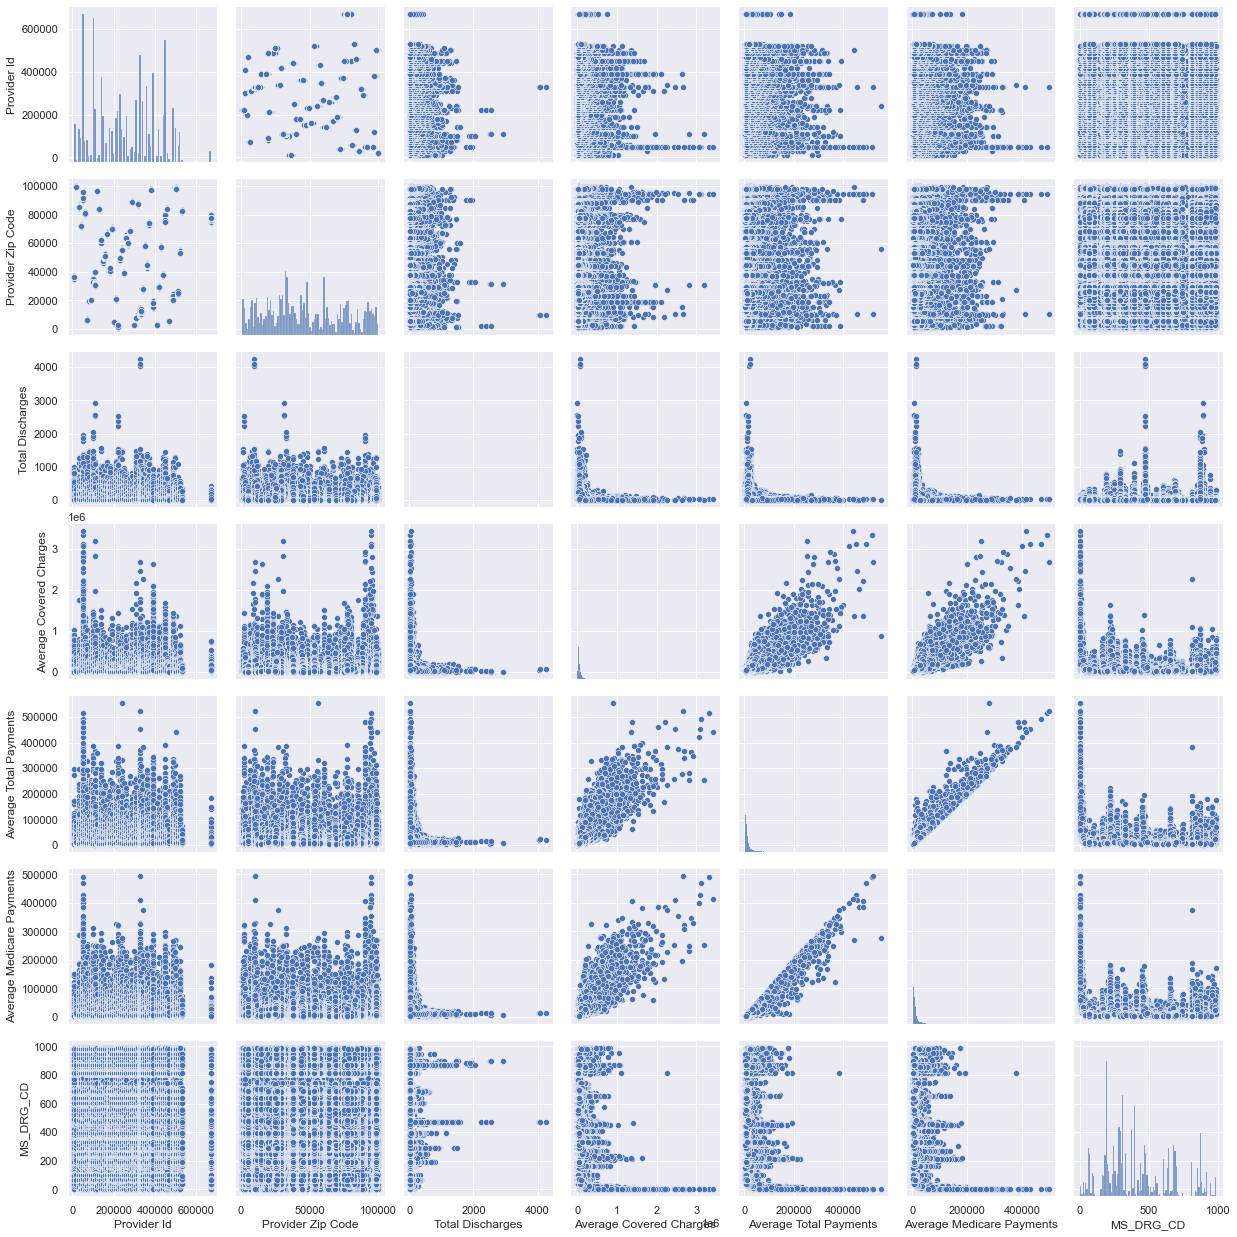

In [85]:
sns.pairplot(prov)
plt.show()

In [87]:
# Means are consistently more than the Median, suggesting highly Right skewed Data

prov.describe(include='all').fillna('-')

DRG Definition Provider Id  \
count                                                     586611   586,611.0   
unique                                                       662     3,260.0   
top     871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W MCC   100,007.0   
freq                                                        8506     1,179.0   
mean                                                           -           -   
std                                                            -           -   
min                                                            -           -   
25%                                                            -           -   
50%                                                            -           -   
75%                                                            -           -   
max                                                            -           -   

                  Provider Name Provider Street Address Provider City  \
count                    586611                  586611        586611   
unique                     3470                    3352          1941   
top     GOOD SAMARITAN HOSPITAL        601 E ROLLINS ST     BALTIMORE   
freq                       1543                    1179          4915   
mean                          -                       -             -   
std                           -                       -             -   
min                           -                       -             -   
25%                           -                       -             -   
50%                           -                       -             -   
75%                           -                       -             -   
max                           -                       -             -   

       Provider State Provider Zip Code  \
count          586611         586,611.0   
unique             51           2,986.0   
top                CA          77,030.0   
freq            45500           1,821.0   
mean                -                 -   
std                 -                 -   
min                 -                 -   
25%                 -                 -   
50%                 -                 -   
75%                 -                 -   
max                 -                 -   

       Hospital Referral Region (HRR) Description Total Discharges  \
count                                      586611        586,611.0   
unique                                        306                -   
top                                   MA - Boston                -   
freq                                        12212                -   
mean                                            -             37.4   
std                                             -             55.9   
min                                             -             11.0   
25%                                             -             14.0   
50%                                             -             22.0   
75%                                             -             39.0   
max                                             -          4,255.0   

       Average Covered Charges Average Total Payments  \
count                586,611.0              586,611.0   
unique                       -                      -   
top                          -                      -   
freq                         -                      -   
mean                  61,339.2               14,076.7   
std                   73,608.5               14,862.0   
min                    1,520.8                2,365.8   
25%                   24,123.2                6,583.1   
50%                   40,248.4                9,730.7   
75%                   71,074.8               15,640.7   
max                3,427,380.0              552,972.1   

       Average Medicare Payments    Year MS_DRG_CD  
count                  586,611.0  586611 586,611.0  
unique                         -       3     604.0  
top       

In [6]:
prov.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region (HRR) Description',
       'Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments', 'Year', 'MS_DRG_CD'],
      dtype='object')

In [7]:
# prov=prov.drop(columns=['Year'])
# prov=prov.drop_duplicates()
#prov.loc[prov['Provider Id']==50441,:].sort_values(by='MS_DRG_CD')


prov = prov.groupby(['Provider Id', 'Provider Name','Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region (HRR) Description','MS_DRG_CD']).agg({'Total Discharges':'sum','Average Covered Charges':'mean', 'Average Total Payments':'mean',
       'Average Medicare Payments':'mean'}).sort_values(by=['Provider Id','MS_DRG_CD']).reset_index()
prov.head(100)

Provider Id                     Provider Name Provider Street Address  \
0         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
1         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
2         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
3         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
4         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
5         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
6         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
7         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
8         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
9         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
10        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
11        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
12        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
13        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
14        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
15        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
16        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
17        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
18        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
19        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
20        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
21        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
22        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
23        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
24        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
25        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
26        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
27        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
28        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
29        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
30        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
31        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
32        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
33        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
34        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
35        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
36        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
37        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
38        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
39        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
40        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
41        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
42        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
43        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
44        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
45        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
46        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
47        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
48        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
49        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
50        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   


Index(['Total Discharges', 'Average Total Payments',
       'Average Medicare Payments'],
      dtype='object')


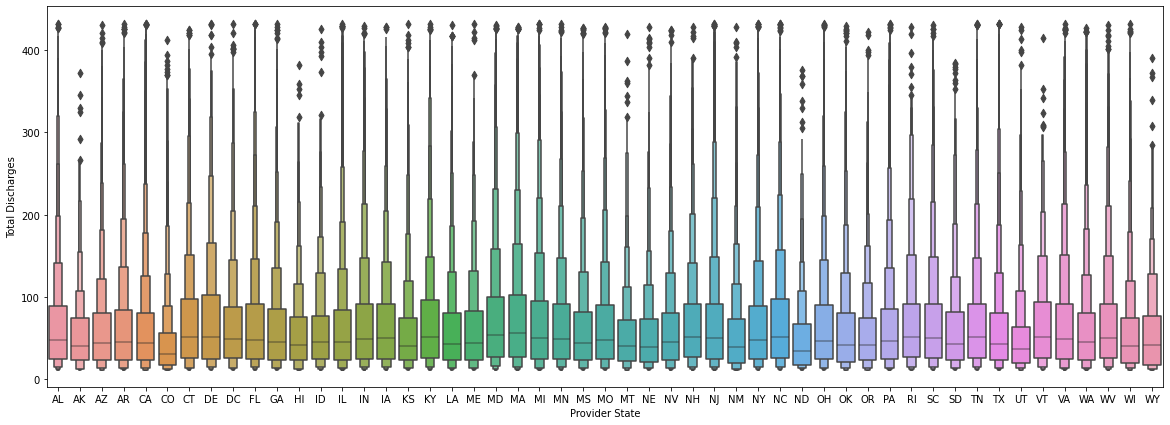

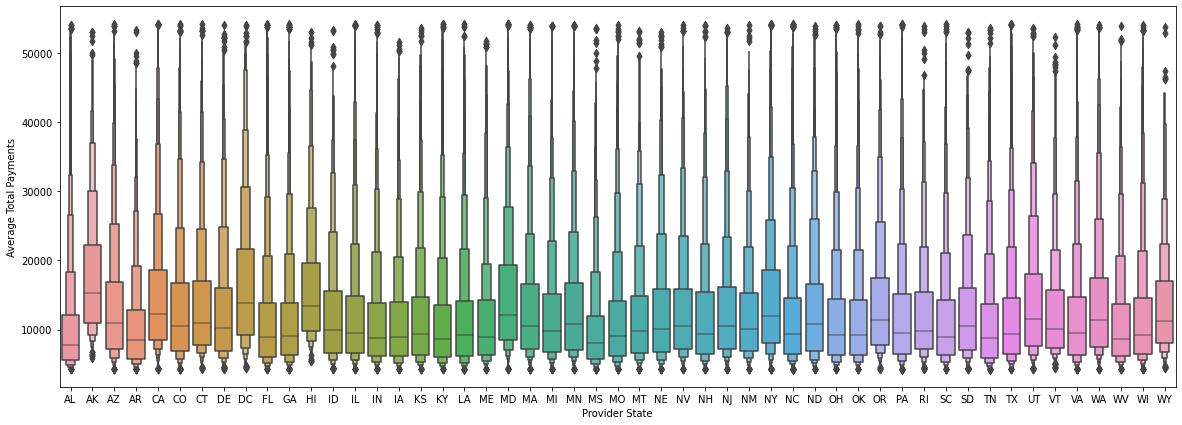

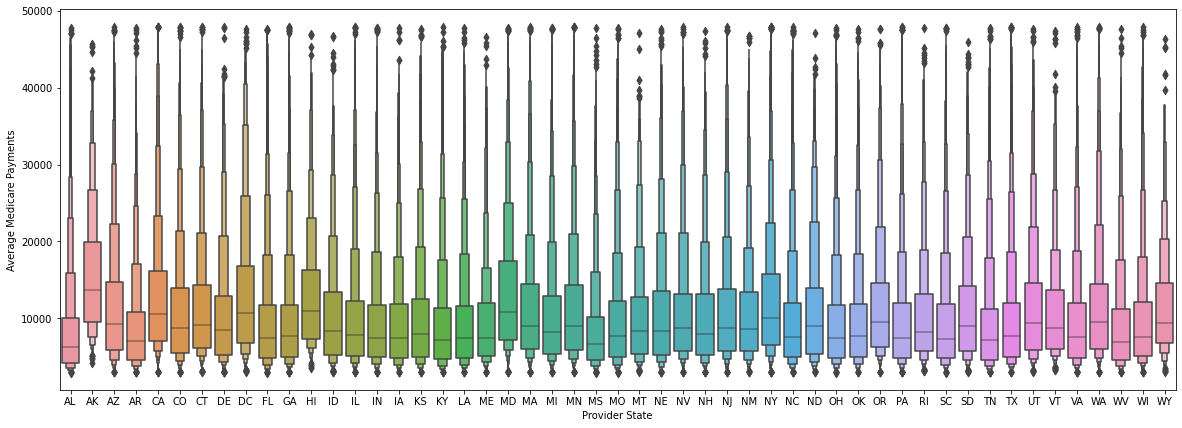

In [40]:
sel = prov.set_index(['Provider State'])[['Total Discharges','Average Total Payments','Average Medicare Payments']]
print(sel.columns)

for col in sel:
    colmax = sel[col].quantile(0.98)
    colmin = sel[col].quantile(0.02)
    sel_trt = sel[(sel[col]>colmin) & (sel[col]<colmax)].reset_index()
    plt.figure(figsize=(20,7))
    sns.boxenplot(data=sel_trt, x=sel_trt['Provider State'], y= sel_trt[col])
    plt.show()

In [112]:
colmax = prov['Average Medicare Payments'].quantile(0.99)
prov_trt_max = prov[(prov['Average Medicare Payments']>colmax)]
prov_trt_max.groupby(['Provider State']).agg({'Total Discharges':'sum', 'Average Covered Charges':'mean', 'Average Total Payments':'mean', 'Average Medicare Payments':'mean'}).sort_values(by='Total Discharges',ascending=False)
#prov_trt_max.describe(include='all').fillna('-')

Total Discharges  Average Covered Charges  \
Provider State                                              
CA                         27856                599,394.0   
NY                         19699                401,555.7   
MD                          8469                101,679.9   
MA                          6988                274,585.9   
TX                          5981                540,809.2   
PA                          5732                622,753.3   
FL                          5408                590,882.9   
MI                          4594                294,398.4   
NJ                          4482                509,913.9   
MN                          4183                297,153.9   
OH                          3616                450,789.9   
IL                          3599                405,798.9   
NC                          3185                342,898.9   
VA                          2777                478,127.1   
MO                          2638                391,987.4   
GA                          2408                442,571.7   
WA                          2332                409,332.5   
TN                          2139                421,533.6   
CT                          1965                341,674.4   
SC                          1818                417,467.5   
IN                          1681                410,876.6   
AZ                          1595                418,547.3   
CO                          1391                558,709.0   
KY                          1322                406,730.0   
DC                          1253                466,763.0   
OK                          1210                471,107.7   
NV                          1153                653,457.1   
OR                          1151                285,884.8   
WI                          1046                401,325.3   
AL                          1008                502,933.1   
AR                           900                320,027.6   
LA                           775                452,830.7   
NE                           698                415,648.4   
MS                           652                358,010.5   
DE                           531                250,659.7   
UT                           528                269,250.3   
IA                           528                330,041.2   
ME                           514                318,193.2   
NH                           482                296,095.2   
WV                           424                281,236.3   
NM                           346                267,663.1   
AK                           344                326,564.7   
RI                           330                253,850.0   
KS                           327                492,273.1   
HI                           271                300,813.9   
ND                           177                303,582.7   
SD                           146                304,320.8   
MT                           131                253,579.4   
VT                           112                282,844.8   
ID                            44                365,246.3   
WY                            34                 99,973.7   

                Average Total Payments  Average Medicare Payments  
Provider State                                                     
CA                           109,522.7                  100,510.8  
NY                           112,365.4                   99,981.1  
MD                            93,776.6                   90,056.4  
MA                           103,243.8                   96,025.8  
TX                           113,736.3                   97,854.4  
PA                           116,378.5                   98,141.5  
FL                           106,868.8                   96,605.2  
MI                           105,028.9                   95,766.8  
NJ                            98,365.3                   89,142.8  
MN                           108,4

In [113]:
prov.groupby(['Provider Id','Provider Zip Code'])['Provider Id'].nunique().sort_values(ascending=False)

Provider Id  Provider Zip Code
670122       77385                1
150166       46307                1
150181       46037                1
150179       46256                1
150177       46545                1
150176       47129                1
150175       47630                1
150173       47905                1
150172       47150                1
150169       46256                1
150168       46804                1
150167       46845                1
150165       46321                1
150183       47403                1
150162       46237                1
150161       46032                1
150160       46278                1
150158       46123                1
150157       46032                1
150153       46290                1
150150       46825                1
150146       46755                1
150133       46580                1
150128       46227                1
150182       46032                1
160001       50158                1
160104       52722               

In [8]:
#Extracting additional data from a PDF containing info on DRG Codes

tables = tabula.read_pdf("C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\176744_2008_BSA_Inpatient_Claims_PUF_DataDic_CB.pdf",pages=[2,3,4,5,6,7,8,9,10,11,12],multiple_tables=True)

In [9]:
#Extracting additional data from a PDF containing info on DRG Codes

dict0 = {'Variable\rValue':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
          'Included MS-\rDRG codes':['001; 002','003','004','005; 006','007','008','009','010','011; 012; 013','020; 021; 022','023; 024','025; 026; 027','028; 029; 030','031; 032; 033','034; 035; 036','037; 038; 039','040; 041; 042'],
         'Formatted Value':['Heart transplant or implant of heart assist system','ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.','Trach w MV 96+ hrs or PDX exc face, mouth & neck w/o maj O.R.','Liver transplant','Lung transplant','Simultaneous pancreas/kidney transplant','Bone marrow transplant','Pancreas transplant','Tracheostomy for face,mouth & neck diagnoses','Intracranial vascular procedures w PDX hemorrhage','Cranio w major dev impl/acute complex CNS PDX','Craniotomy & endovascular intracranial procedures','Spinal procedures','Ventricular shunt procedures','Carotid artery stent procedure','Extracranial procedures','Periph/cranial nerve & other nerv syst']}
table0 = pd.DataFrame(dict0)

In [10]:
#Extracting additional data from a PDF from CMS.gov website containing info on DRG Codes

table = table0
for i in range(1,len(tables)):
    table = pd.concat([table,tables[i].iloc[:,0:3]])
    
table = table.iloc[:,0:3]

table = table.dropna(how='all',axis=0).reset_index(drop=True)
table['Included MS-\rDRG codes'] = table['Included MS-\rDRG codes'].str.replace(';',',')
table['Included MS-\rDRG codes']=table['Included MS-\rDRG codes'].str.split(',')
table = table.explode('Included MS-\rDRG codes').reset_index(drop=True)
table['Included MS-\rDRG codes'] = table['Included MS-\rDRG codes'].astype('int64')
table.columns = ['IP_CLM_BASE_DRG_CD','MS_DRG_CD','BASE_COND']
table[table.IP_CLM_BASE_DRG_CD.isnull()]
table = table.drop([352,571])
table['IP_CLM_BASE_DRG_CD'] = table['IP_CLM_BASE_DRG_CD'].astype('int64')
table.isna().sum()
table.head(10)

IP_CLM_BASE_DRG_CD  MS_DRG_CD  \
0                   1          1   
1                   1          2   
2                   2          3   
3                   3          4   
4                   4          5   
5                   4          6   
6                   5          7   
7                   6          8   
8                   7          9   
9                   8         10   

                                                             BASE_COND  
0                   Heart transplant or implant of heart assist system  
1                   Heart transplant or implant of heart assist system  
2  ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.  
3        Trach w MV 96+ hrs or PDX exc face, mouth & neck w/o maj O.R.  
4                                                     Liver transplant  
5                                                     Liver transplant  
6                                                      Lung transplant  
7                              Simultaneous pancreas/kidney transplant  
8                                               Bone marrow transplant  
9                                                  Pancreas transplant

In [11]:
#Merging additional data from the DRG PDF into the original Provider Dataset

prov = pd.merge(prov,table,how='left',on='MS_DRG_CD')
prov.head(100)

Provider Id                     Provider Name Provider Street Address  \
0         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
1         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
2         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
3         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
4         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
5         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
6         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
7         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
8         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
9         10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
10        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
11        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
12        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
13        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
14        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
15        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
16        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
17        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
18        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
19        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
20        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
21        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
22        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
23        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
24        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
25        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
26        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
27        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
28        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
29        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
30        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
31        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
32        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
33        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
34        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
35        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
36        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
37        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
38        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
39        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
40        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
41        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
42        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
43        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
44        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
45        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
46        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
47        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
48        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
49        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   
50        10001  SOUTHEAST ALABAMA MEDICAL CENTER  1108 ROSS CLARK CIRCLE   


In [12]:
# Extracting additional info available on DRG codes from Wikipedia

DRG_Class = pd.DataFrame()
for i in range(drg_cat.shape[0]):
    #print(i)
    diff = drg_cat.iloc[i,3] - drg_cat.iloc[i,2]
    df = pd.DataFrame()
    for j in range(diff+1):
        #print(j)
        df = df.append(pd.DataFrame(drg_cat.iloc[i,:]).T)
    df.index = range(drg_cat.iloc[i,2],drg_cat.iloc[i,3]+1)
    DRG_Class = DRG_Class.append(df)
DRG_Class=DRG_Class.reset_index()
DRG_Class.drop(['DRG_low','DRG_high'],axis=1,inplace=True)
DRG_Class.columns=['MS_DRG_CD','MDC','Condition_Family']
DRG_Class.head()

MS_DRG_CD MDC Condition_Family
0          1 0.0          Pre-MDC
1          2 0.0          Pre-MDC
2          3 0.0          Pre-MDC
3          4 0.0          Pre-MDC
4          5 0.0          Pre-MDC

In [143]:
dftd.head(100)

Provider Id                                       Provider Name  \
1311          10033                      UNIVERSITY OF ALABAMA HOSPITAL   
5674          30002          BANNER - UNIVERSITY MEDICAL CENTER PHOENIX   
9406          30103                                MAYO CLINIC HOSPITAL   
10675         40007                            CHI-ST VINCENT INFIRMARY   
13193         40114           BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK   
13194         40114           BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK   
14813         50025   UC SAN DIEGO HEALTH HILLCREST - HILLCREST MED CTR   
15985         50047  CALIFORNIA PACIFIC MEDICAL CENTER- VAN NESS CAMPUS   
15986         50047  CALIFORNIA PACIFIC MEDICAL CTR-PACIFIC CAMPUS HOSP   
18007         50100                             SHARP MEMORIAL HOSPITAL   
18524         50108                   SUTTER MEDICAL CENTER, SACRAMENTO   
23987         50262                RONALD REAGAN U C L A MEDICAL CENTER   
28565         50441                                STANFORD HEALTH CARE   
28944         50454                                 UCSF MEDICAL CENTER   
32859         50625                         CEDARS-SINAI MEDICAL CENTER   
37341         60024           UNIVERSITY OF COLORADO HOSPITAL AUTHORITY   
37342         60024           UNIVERSITY OF COLORADO HOSPITAL AUTHORITY   
41182         70022                             YALE-NEW HAVEN HOSPITAL   
41658         70025                                   HARTFORD HOSPITAL   
44405         90011                  MEDSTAR WASHINGTON HOSPITAL CENTER   
45525        100007                                ADVENTHEALTH ORLANDO   
45526        100007                                    FLORIDA HOSPITAL   
47844        100022                           JACKSON MEMORIAL HOSPITAL   
55104        100113                           UF HEALTH SHANDS HOSPITAL   
56093        100128                              TAMPA GENERAL HOSPITAL   
56974        100151                                         MAYO CLINIC   
64606        100289                           CLEVELAND CLINIC HOSPITAL   
66338        110010                           EMORY UNIVERSITY HOSPITAL   
70363        110083                                   PIEDMONT HOSPITAL   
78539        140088            THE UNIVERSITY OF CHICAGO MEDICAL CENTER   
83674        140208           ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER   
86167        140276                    LOYOLA UNIVERSITY MEDICAL CENTER   
86528        140281                      NORTHWESTERN MEMORIAL HOSPITAL   
91472        150084               ST VINCENT HOSPITAL & HEALTH SERVICES   
94972        160058               UNIVERSITY OF IOWA HOSPITAL & CLINICS   
97259        170040                       UNIVERSITY OF KANSAS HOSPITAL   
101402       180040              JEWISH HOSPITAL & ST MARY'S HEALTHCARE   
102186       180067                     UNIVERSITY OF KENTUCKY HOSPITAL   
105691       190036                              OCHSNER MEDICAL CENTER   
110568       210002               UNIVERSITY OF MARYLAND MEDICAL CENTER   
119012       220071                      MASSACHUSETTS GENERAL HOSPITAL   
121297       220110                        BRIGHAM AND WOMEN'S HOSPITAL   
121785       220116                                TUFTS MEDICAL CENTER   
124568       230038                SPECTRUM HEALTH - BUTTERWORTH CAMPUS   
125063       230046                UNIVERSITY OF MICHIGAN HEALTH SYSTEM   
125531       230053                                 HENRY FORD HOSPITAL   
133193       240010                      MAYO CLINIC HOSPITAL ROCHESTER   
134833       240057                        ABBOTT NORTHWESTERN HOSPITAL   
135621       240080   UNIVERSITY OF MINNESOTA  MEDICAL CENTER, FAIRVIEW   
137102       250001                UNIVERSITY OF MISSISSIPPI MED CENTER   
142194       260032                              BARNES JEWISH HOSPITAL   
145698       260138                    ST LUKES HOSPITAL OF KANSAS CITY   
148732       280013              

In [43]:
dftd = pd.DataFrame()
for drg in prov.groupby(['MS_DRG_CD']).groups:
    intr = prov[prov.MS_DRG_CD==drg]
    tmp = intr.groupby('Provider Id')['Average Medicare Payments'].mean().reset_index()
    tmp = tmp.assign(Idx_MediPay_DRG = 100*tmp['Average Medicare Payments']/np.mean(tmp['Average Medicare Payments']))
    dftd = dftd.append(tmp)
# dftd.head(100)

dfts = pd.DataFrame()
for st in prov.groupby(['Provider State']).groups:
    intr = prov[prov['Provider State']==st]
    tmp = intr.groupby('Provider Id')['Average Medicare Payments'].mean().reset_index()
    tmp = tmp.assign(Idx_MediPay_St = 100*tmp['Average Medicare Payments']/np.mean(tmp['Average Medicare Payments']))
    dfts = dfts.append(tmp)
# dfts.head(100)

dftd = pd.merge(dftd,dfts,how='left',on=['Provider Id'])

dftn = prov.groupby('Provider Id')['Average Medicare Payments'].mean().reset_index()
dftn['Idx_MediPay_Ntl'] = 100*prov['Average Medicare Payments']/np.mean(prov['Average Medicare Payments'])
dftn
#dftn.head(100)

dftd =  pd.merge(dftd,dftn,how='left',on=['Provider Id'])

dftd.drop(columns=['Average Medicare Payments_x','Average Medicare Payments_y','Average Medicare Payments'],inplace=True)
dftd.sort_values(by='Idx_MediPay_Ntl',ascending=False).head(100)

index  Provider Id  Idx_MediPay_DRG  Idx_MediPay_St  Idx_MediPay_Ntl
0   163381       190255             66.1            91.0          1,232.6
1   172451       190255             69.6            91.0          1,232.6
2   163380       190251             54.2           147.3          1,126.4
3   156276       190251             72.3           147.3          1,126.4
4   157616       190251             68.2           147.3          1,126.4
5   172450       190251             80.0           147.3          1,126.4
6    89987       140082            115.3           118.4            888.0
7   143751       140082            119.7           118.4            888.0
8    11436       140082            114.6           118.4            888.0
9    15148       140082            122.9           118.4            888.0
10  113012       140082            115.5           118.4            888.0
11  130054       140082            121.9           118.4            888.0
12   39890       140082            116.7           118.4            888.0
13   45264       140082            119.6           118.4            888.0
14   83333       140082            117.4           118.4            888.0
15  142550       140082            108.4           118.4            888.0
16  215899       140082            116.1           118.4            888.0
17  206629       140082            119.1           118.4            888.0
18  140209       140082            121.6           118.4            888.0
19  104478       140082            117.0           118.4            888.0
20  159739       140082            119.4           118.4            888.0
21   18306       140082            118.9           118.4            888.0
22  163050       140082            122.4           118.4            888.0
23   21999       140082            119.5           118.4            888.0
24  108915       140082            118.2           118.4            888.0
25  161364       140082            115.8           118.4            888.0
26   85371       140082            121.3           118.4            888.0
27  159049       140082            103.8           118.4            888.0
28  160507       140082            130.4           118.4            888.0
29  196103       140082            119.3           118.4            888.0
30  177812       140082            137.7           118.4            888.0
31   52325       140082            117.2           118.4            888.0
32  138266       140082            111.4           118.4            888.0
33   49569       140082            119.1           118.4            888.0
34  169084       140082            119.8           118.4            888.0
35  100004       140082            118.9           118.4            888.0
36   71397       140082            119.6           118.4            888.0
37  134790       140082            122.3           118.4            888.0
38  106677       140082            124.8           118.4            888.0
39  212571       140082            117.3           118.4            888.0
40   97311       140082            120.4           118.4            888.0
41   91971       140082            118.4           118.4            888.0
42  127984       140082            111.4           118.4            888.0
43  172256       140082            118.6           118.4            888.0
44  249543       140082            108.7           118.4            888.0
45  210140       140082            126.1           118.4            888.0
46  227180       140082            111.5           118.4            888.0
47   24525       140082            116.8           118.4            888.0
48  191993       140082            118.2           118.4            888.0
49  222913       140082            121.7           118.4            888.0
50   35578       140082            117.0           118.4            888.0
51   33652       140082            114.7           118.4            888.0
52   47526       140082            114.7           118.4            888.0
53  24144

In [41]:
# Merging Additional Info from Wikipedia into our original Provider data

prov = pd.merge(prov,DRG_Class, how='left',on='MS_DRG_CD')
prov = pd.merge(prov,dftd, how='left',on='Provider Id')

# # Constructing Additional Variables in Provider Data

prov['Covered_Charges_total'] = prov['Average Covered Charges']*prov['Total Discharges']
prov['Payments_total'] = prov['Average Total Payments']*prov['Total Discharges']
prov['Medicare_Payments_total'] = prov['Average Medicare Payments']*prov['Total Discharges']
prov['Cost_Charge_Ratio'] = np.where(prov['Average Medicare Payments']==0, 1,prov['Average Covered Charges']/prov['Average Medicare Payments'])

print(prov.columns)

Index(['Provider Id', 'Provider Name', 'Provider Street Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
       'Hospital Referral Region (HRR) Description', 'MS_DRG_CD',
       'Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments', 'IP_CLM_BASE_DRG_CD', 'BASE_COND', 'MDC',
       'Condition_Family', 'Idx_MediPay_DRG', 'Idx_MediPay_St',
       'Idx_MediPay_Ntl', 'Covered_Charges_total', 'Payments_total',
       'Medicare_Payments_total', 'Cost_Charge_Ratio'],
      dtype='object')


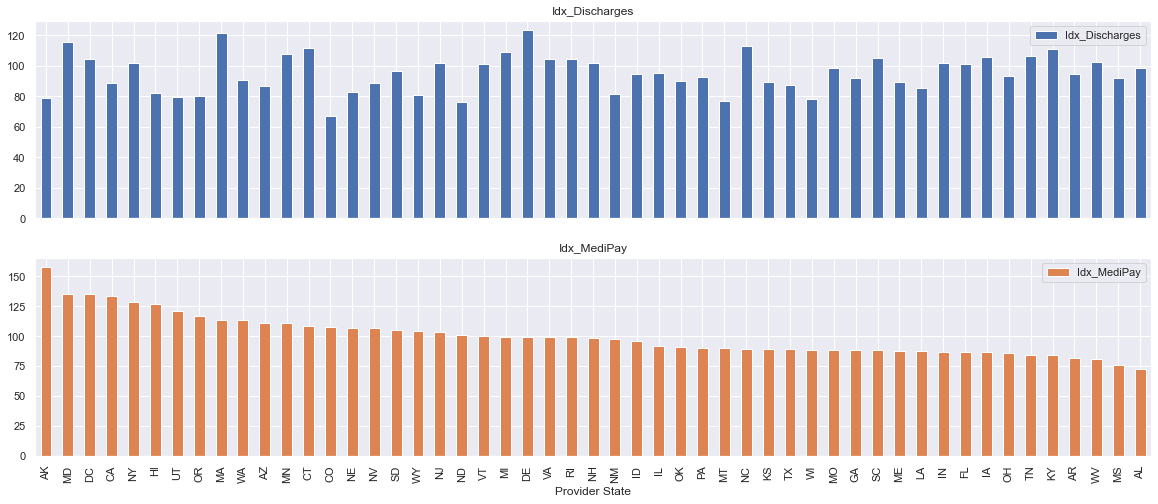

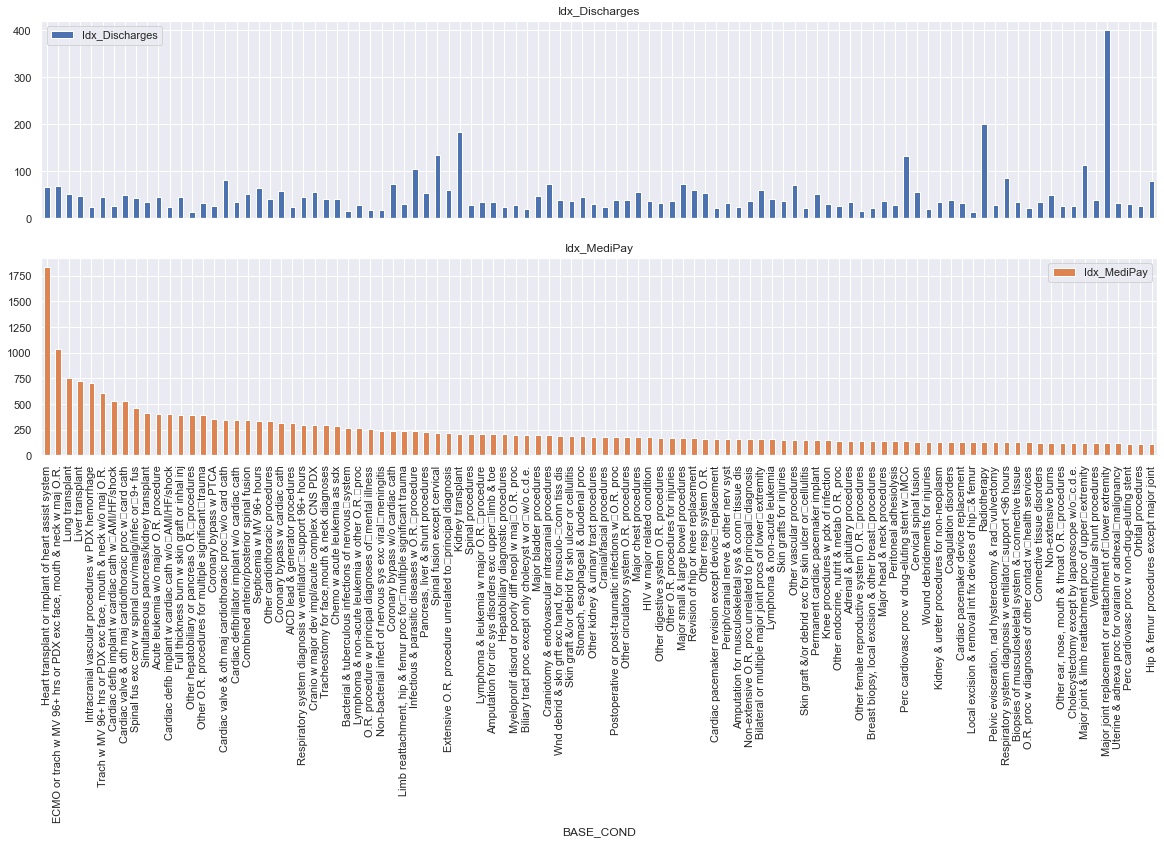

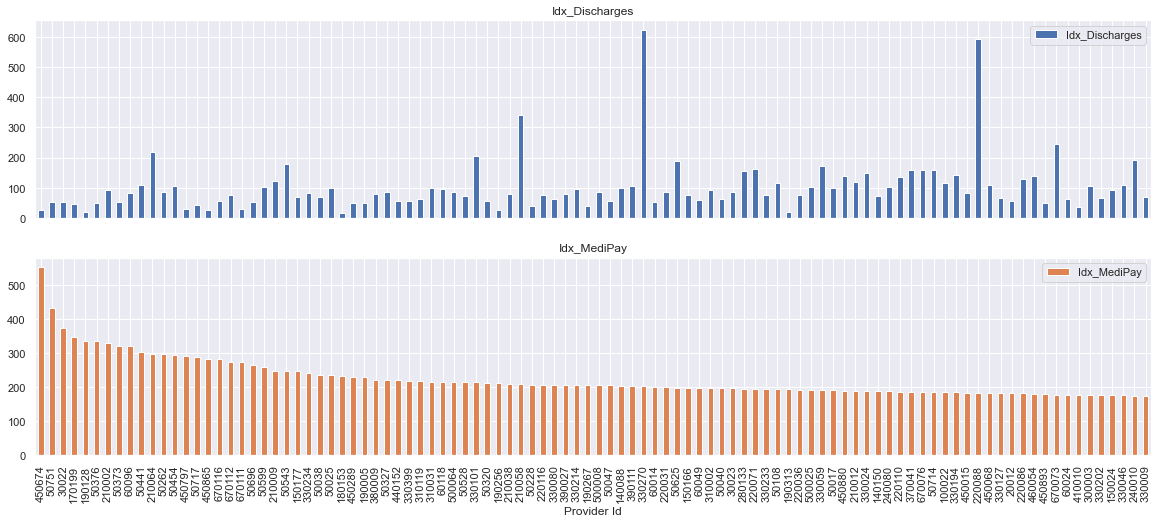

In [121]:
prov.groupby(['Provider State']).agg({'Idx_Discharges':'mean','Idx_MediPay':'mean'}).sort_values(by='Idx_MediPay',ascending=False).plot(kind='bar',figsize=(20,8),subplots=True)
plt.show()
prov.groupby(['BASE_COND']).agg({'Idx_Discharges':'mean','Idx_MediPay':'mean'}).sort_values(by='Idx_MediPay',ascending=False)[:100].plot(kind='bar',figsize=(20,8),subplots=True)
plt.show()
prov.groupby(['Provider Id']).agg({'Idx_Discharges':'mean','Idx_MediPay':'mean'}).sort_values(by='Idx_MediPay',ascending=False)[:100].plot(kind='bar',figsize=(20,8),subplots=True)
plt.show()

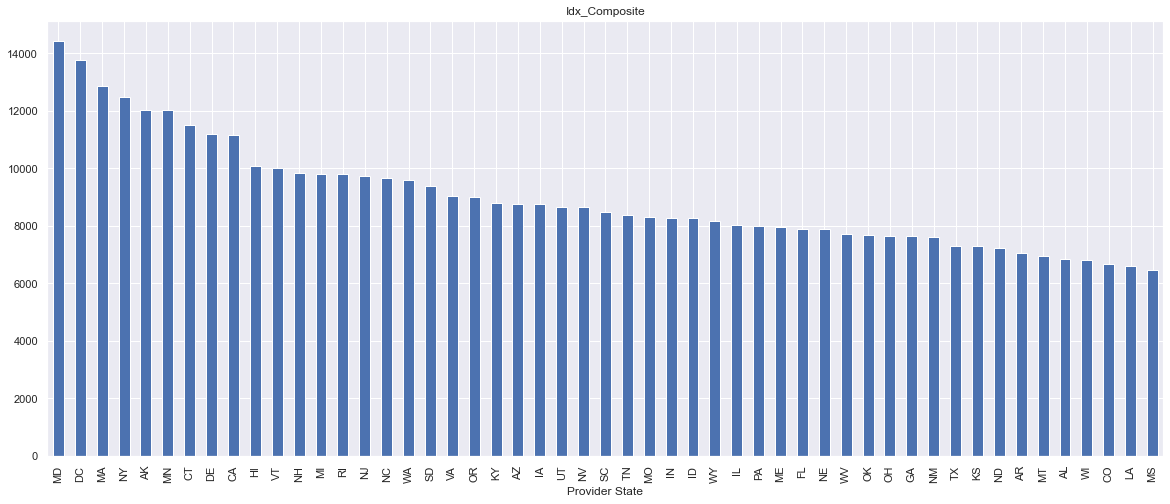

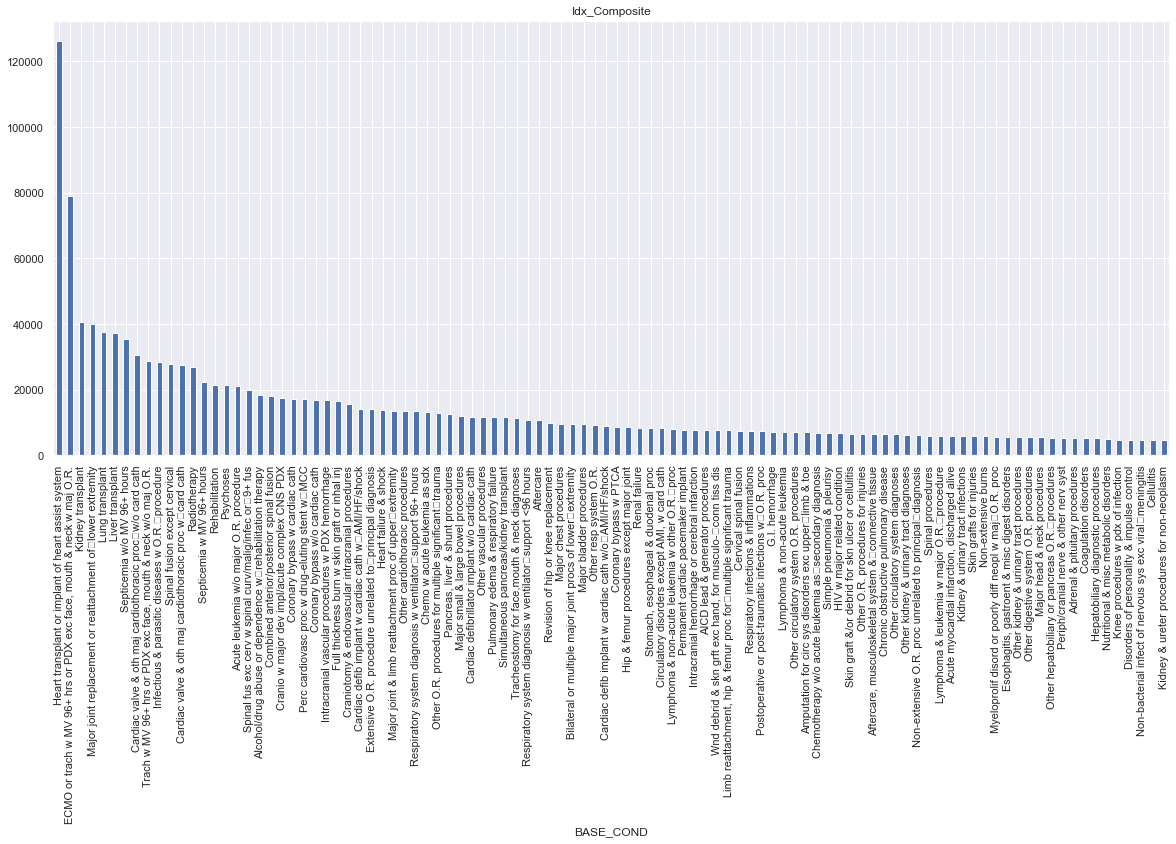

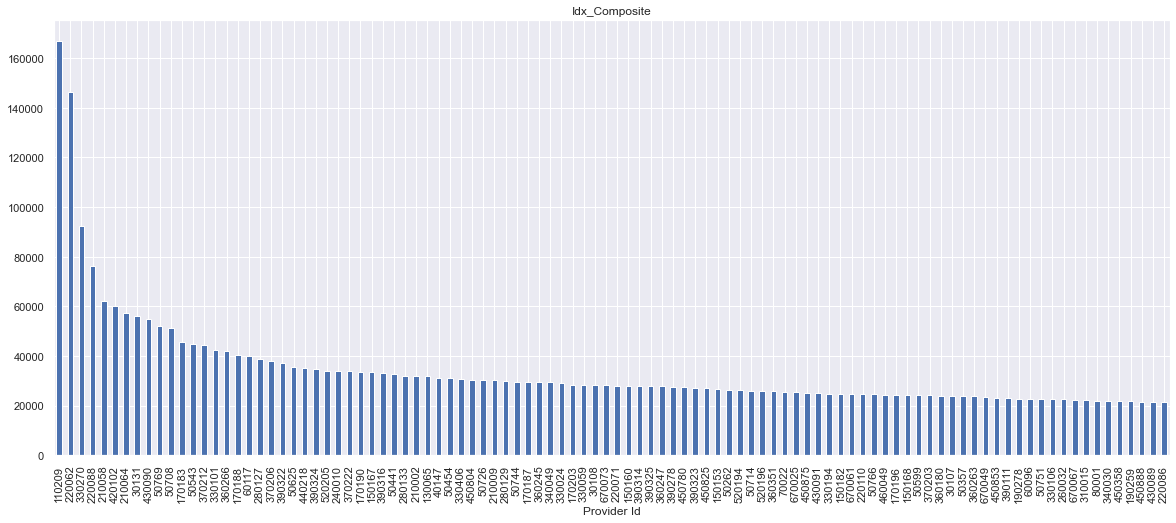

In [122]:
prov['Idx_Composite'] = prov.Idx_Discharges*prov.Idx_MediPay
prov.groupby(['Provider State'])['Idx_Composite'].mean().sort_values(ascending=False).plot(kind='bar',figsize=(20,8),subplots=True)
plt.show()
prov.groupby(['BASE_COND'])['Idx_Composite'].mean().sort_values(ascending=False)[:100].plot(kind='bar',figsize=(20,8),subplots=True)
plt.show()
prov.groupby(['Provider Id'])['Idx_Composite'].mean().sort_values(ascending=False)[:100].plot(kind='bar',figsize=(20,8),subplots=True)
plt.show()

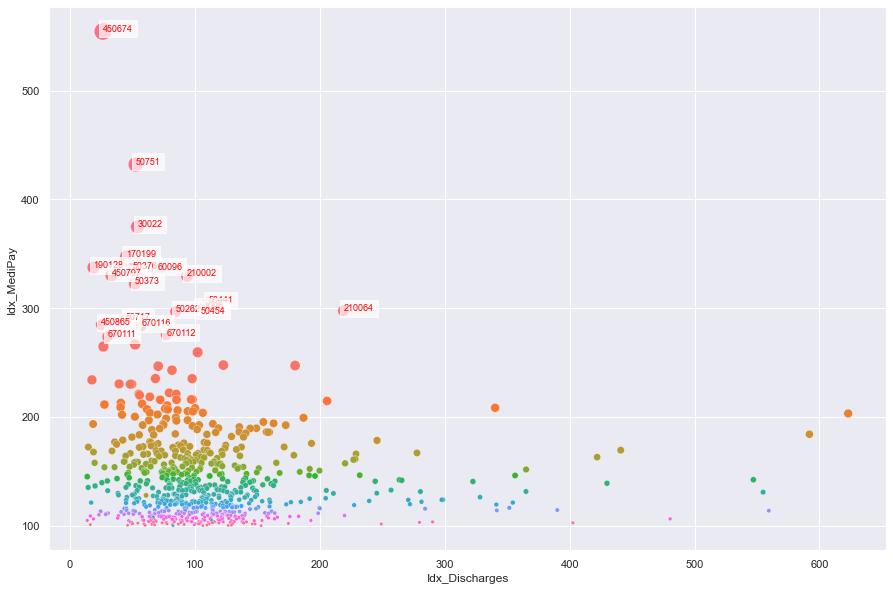

In [123]:
grp = prov.groupby(['Provider Name','Provider Id'])['Idx_Discharges', 'Idx_MediPay'].mean().reset_index()

outl = pd.DataFrame()
for state in grp['Provider State'].unique():
    top50 = grp[grp['Provider State']==state].sort_values(by='Idx_MediPay',ascending=False)[:50]
    outl = pd.concat([outl,top50])

outl = outl[outl.Idx_MediPay>100]
#outl = outl[outl.Idx_Discharges>100]
outl=outl.sort_values(by='Idx_MediPay',ascending=False)
sns.set_theme(style="darkgrid")

plt.figure(figsize=(15,10))
sns.scatterplot(data=outl, y="Idx_MediPay", x="Idx_Discharges", hue="Provider Name", size="Idx_MediPay",sizes=(10,300),legend=None)
for i in range(20):
     plt.text(x=outl.Idx_Discharges.iloc[i],y=outl.Idx_MediPay.iloc[i], s= outl['Provider Id'].iloc[i],
          fontdict=dict(color='red',size=9),
          bbox=dict(facecolor='white',alpha=0.7))
plt.show()

In [50]:
prov.dtypes

Provider Id                                     int64
Provider Name                                  object
Provider Street Address                        object
Provider City                                  object
Provider State                                 object
Provider Zip Code                               int64
Hospital Referral Region (HRR) Description     object
MS_DRG_CD                                       int64
Total Discharges                                int64
Average Covered Charges                       float64
Average Total Payments                        float64
Average Medicare Payments                     float64
IP_CLM_BASE_DRG_CD                            float64
BASE_COND                                      object
MDC                                            object
Condition_Family                               object
Idx_MediPay_DRG                               float64
Idx_MediPay_St                                float64
Idx_MediPay_Ntl             

In [ ]:
temp = prov[['Provider Id','Provider State','Provider City','BASE_COND','Idx_MediPay_DRG','Idx_MediPay_St','Idx_MediPay_Ntl']].dropna()
temp['Provider Id'] = temp['Provider Id'].astype('object')
clustarr = temp.values
kproto = KPrototypes(n_clusters=3, verbose=2,max_iter=3)
clusters = kproto.fit_predict(clustarr, categorical=[0,1,2,3])

In [ ]:
cluster_dict=[]
for c in clusters:
    cluster_dict.append(c)

clustdf['cluster']=cluster_dict

In [ ]:
print(clustdf[clustdf.cluster==0].describe().fillna('-'))
print(clustdf[clustdf.cluster==2].describe().fillna('-'))

In [ ]:
clustdf[clustdf.cluster==0].groupby(['BASE_COND','Provider City','Provider State','Provider Id'])['Average Medicare Payments'].mean().sort_values(ascending=False)[:20].plot(kind='bar',figsize=(20,5),fontsize=9)
plt.xticks(rotation=80)
plt.show()
clustdf[clustdf.cluster==2].groupby(['BASE_COND','Provider City','Provider State','Provider Id'])['Average Medicare Payments'].mean().sort_values(ascending=False)[:20].plot(kind='bar',figsize=(20,5),fontsize=9)
plt.xticks(rotation=80)
plt.show()

### Insights/Statistical Analysis/Modelling - Provider Data

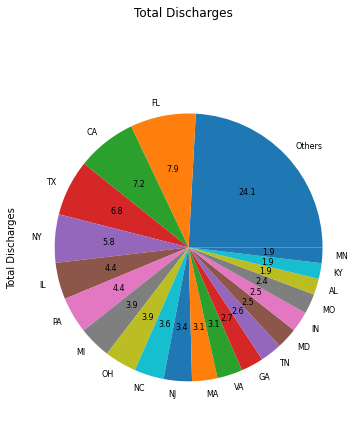

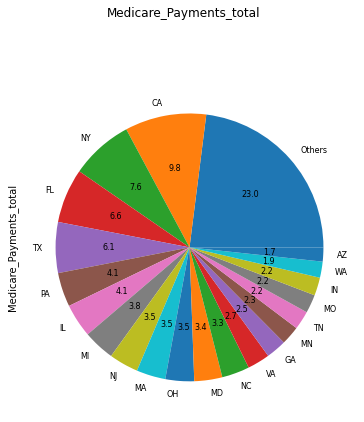

In [17]:
# Making a function to efficiently aggregate & plot data

def grp_plot(grouper,plot_type,topn,*grouped):
    dfts = pd.DataFrame()
    for col in grouped:
        dft=prov.groupby([grouper])[col].sum().sort_values(ascending=False).reset_index().reset_index()
        dft.index.astype('str')
        dfts = dfts.append(100*dft[col]/sum(dft[col]))
        dft.loc[topn:,grouper]='Others'
        dft=dft.groupby([grouper])[col].sum().sort_values(ascending=False)
        if plot_type == 'pie':
            dft.plot(kind=plot_type,subplots=True,title=col,autopct='%.1f',figsize=(6,7),fontsize=8)
            plt.show()
        else: 
            dft.plot(kind=plot_type,subplots=True,title=col,figsize=(6,7),fontsize=8)
            plt.show()

# Plot the aggregated data using the constructed function        
grp_plot('Provider State','pie',20,'Total Discharges','Medicare_Payments_total')

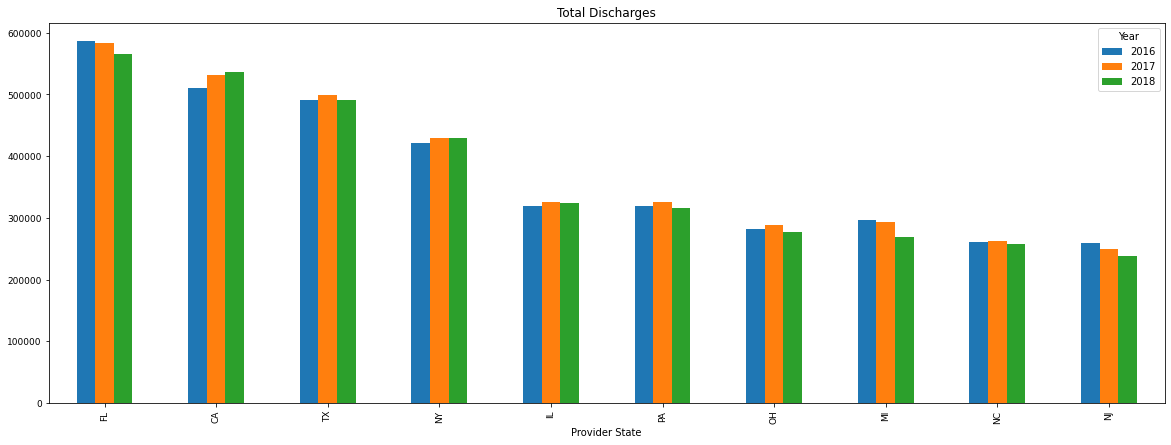

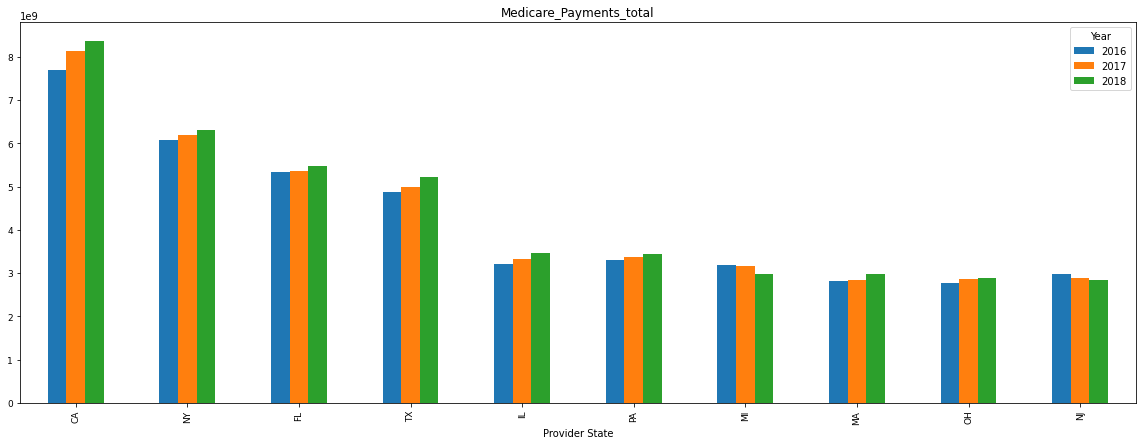

In [18]:
# Analysing Trends in Discharges & Payments over time(2016-2018)

for col in ['Total Discharges','Medicare_Payments_total']:
    prov.groupby(['Provider State','Year'])[col].sum().unstack(level=1).sort_values(by='2018',ascending=False)[:10].stack('Year').unstack(level=1).plot(kind='bar',figsize=(20,7),title=col,fontsize=9)
    #plt.tight_layout()
    plt.show()

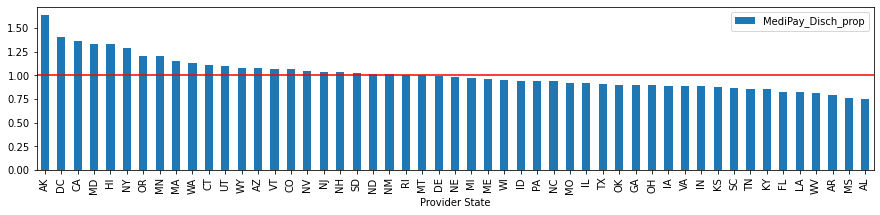

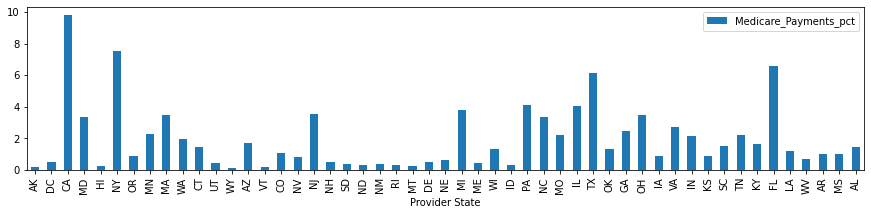

In [19]:
# Introducing Additional Heuristics/Metrics to identify skewed proportions of Medicare allocation across states

temp = prov.groupby(['Provider State']) ['Total Discharges','Medicare_Payments_total'].sum().reset_index()
temp = temp.assign(Total_Discharges_pct = 100*temp['Total Discharges']/sum(temp['Total Discharges']),
                   Medicare_Payments_pct = 100*temp['Medicare_Payments_total']/sum(temp['Medicare_Payments_total']))
temp =  temp.assign(MediPay_Disch_prop = temp['Medicare_Payments_pct']/temp['Total_Discharges_pct'])

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Provider State',y='MediPay_Disch_prop',kind='bar',figsize=(15,3))
plt.axhline(y = 1.0, color = 'r', linestyle = '-')
plt.show()

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Provider State',y='Medicare_Payments_pct',kind='bar',figsize=(15,3))
plt.show()

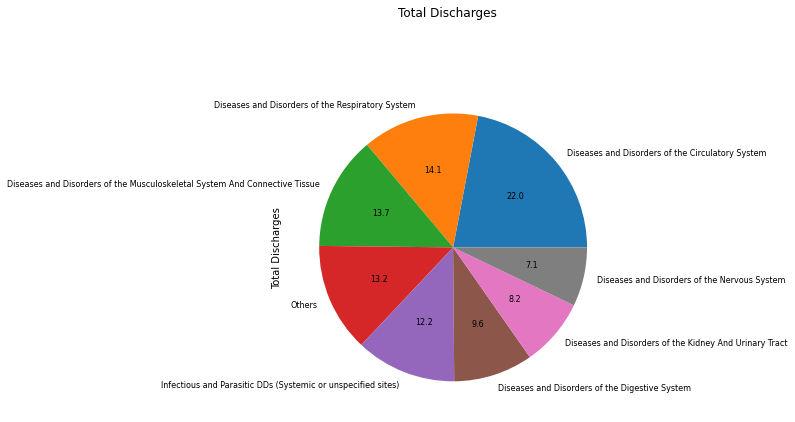

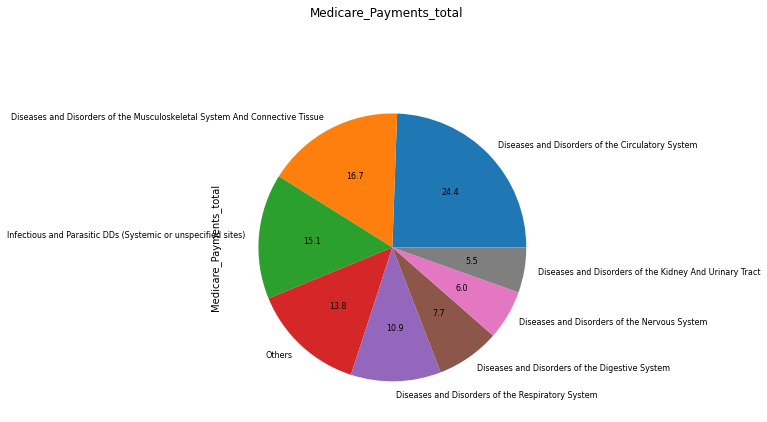

In [20]:
#Aggregating Medicare Payments over 'Major Disease families' - Non granular view (top View) by major diseases

grp_plot('Condition_Family','pie',7,'Total Discharges','Medicare_Payments_total')

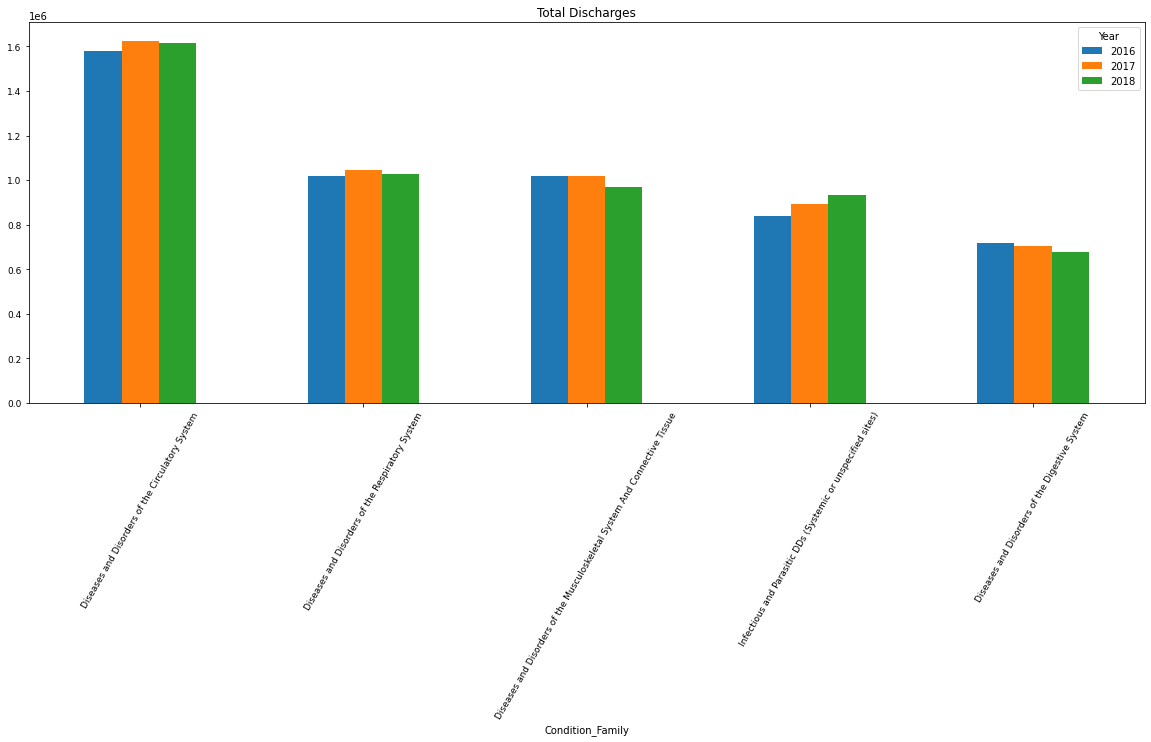

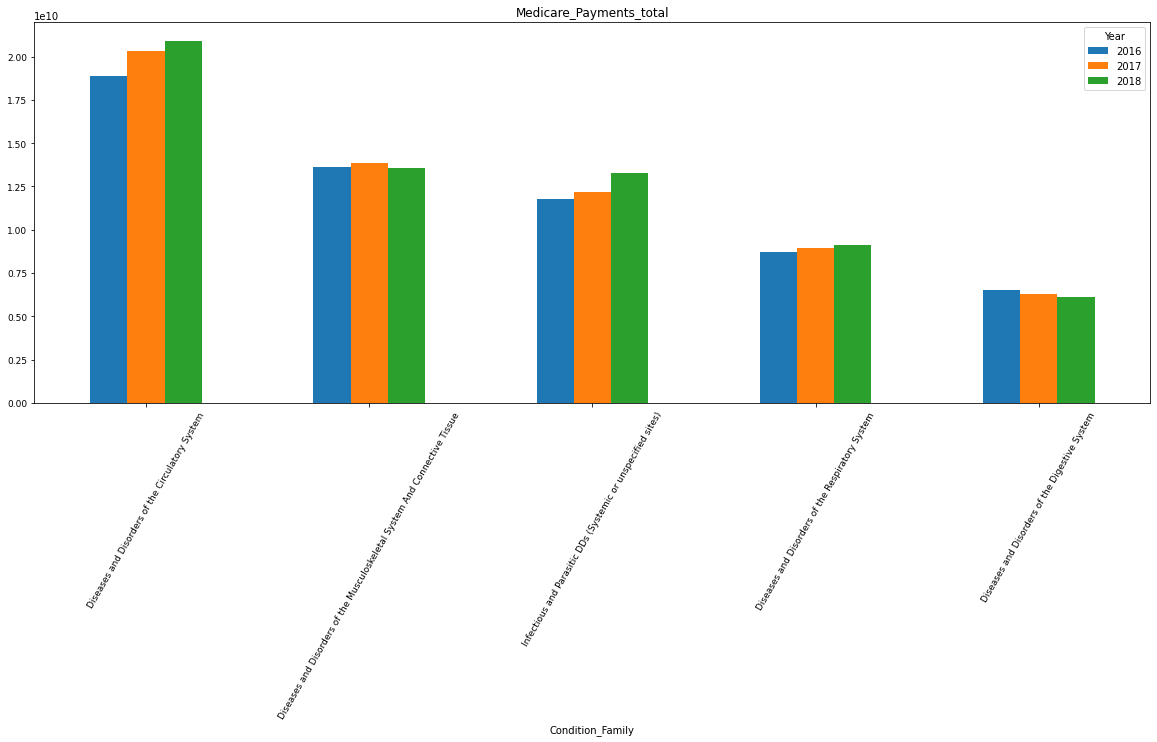

In [21]:
# Plotting & Analysing Number of Infected over time for Major Disease families classification

for col in ['Total Discharges','Medicare_Payments_total']:
    prov.groupby(['Condition_Family','Year'])[col].sum().unstack(level=1).sort_values(by='2018',ascending=False)[:5].stack('Year').unstack(level=1).plot(kind='bar',figsize=(20,7),title=col,fontsize=9)
    plt.xticks(rotation=60)
    plt.show()

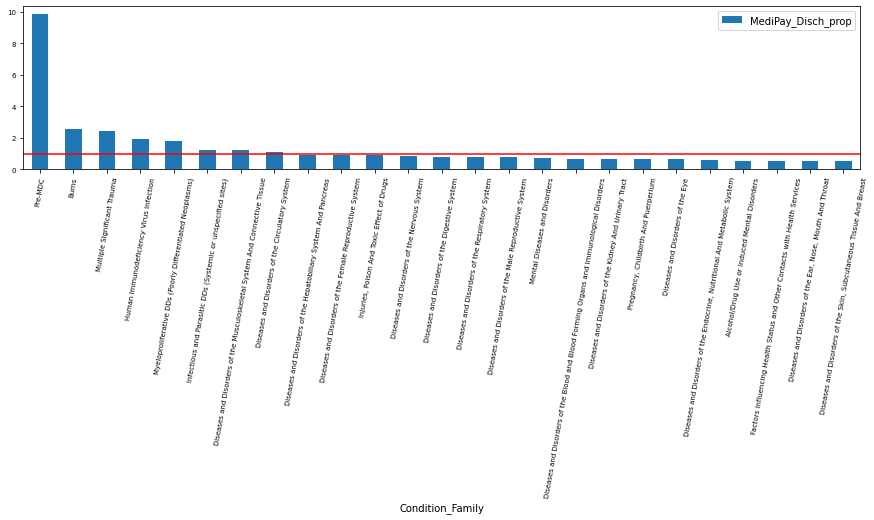

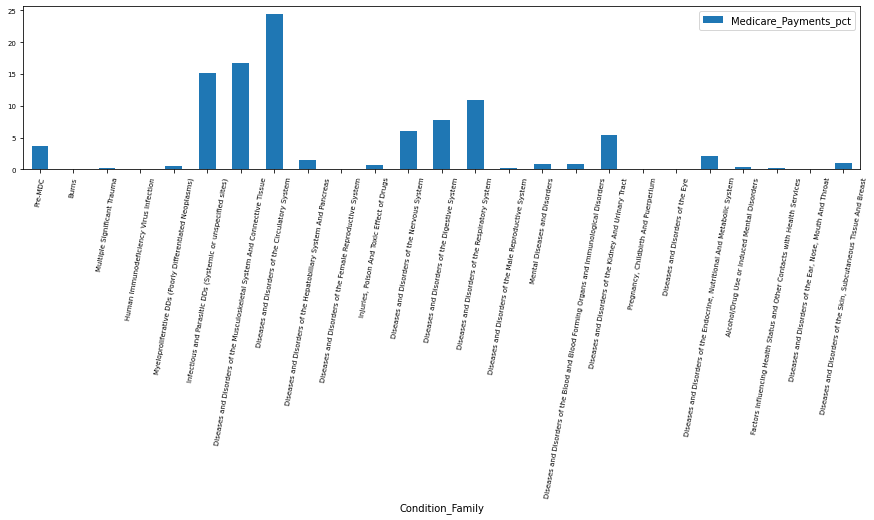

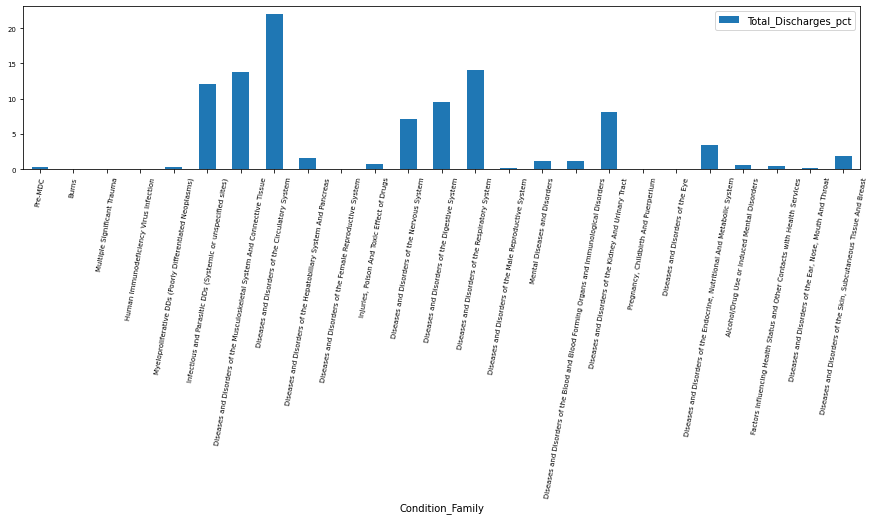

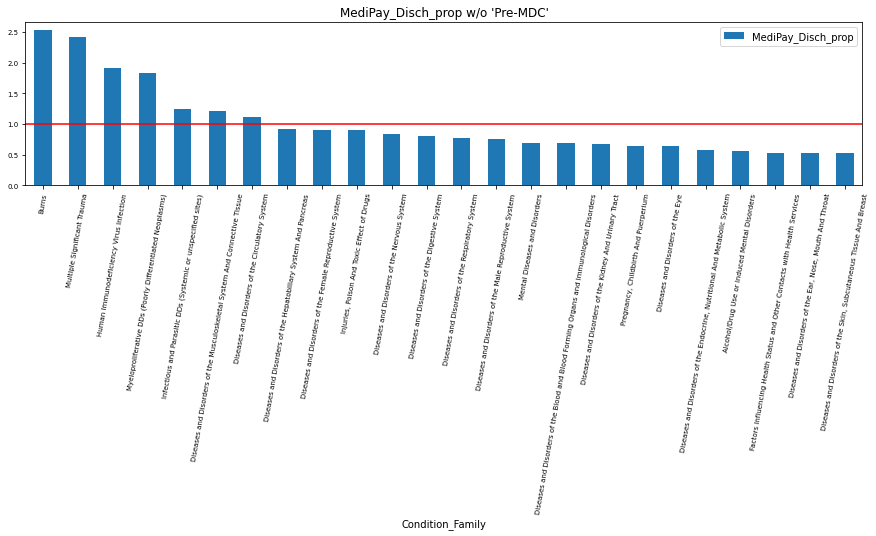

In [22]:
# Additional Heuristic/Metric 'MediPay_Disch_prop' for identifying Diseases that occupy a skewed share of total Medicare Payments

temp = prov.groupby(['Condition_Family']) ['Total Discharges','Medicare_Payments_total'].sum().reset_index()
temp = temp[~temp.Condition_Family.isin(['MDC Category Missing'])].assign(Total_Discharges_pct = 100*temp['Total Discharges']/sum(temp['Total Discharges']),
                   Medicare_Payments_pct = 100*temp['Medicare_Payments_total']/sum(temp['Medicare_Payments_total']))
temp =  temp.assign(MediPay_Disch_prop = temp['Medicare_Payments_pct']/temp['Total_Discharges_pct'])

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='MediPay_Disch_prop',kind='bar',figsize=(15,3),fontsize=7)

# Putting a 'Baseline' = 1.0 for identifying diseases that occupy more than average share per discharge of total Medicare Payments
plt.axhline(y = 1.0, color = 'r', linestyle = '-')
plt.xticks(rotation=80)
plt.show()

# Plots for Discharge & Medicare Payments expressed as percentages

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='Medicare_Payments_pct',kind='bar',figsize=(15,3),fontsize=7)
plt.xticks(rotation=80)
plt.show()

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='Total_Discharges_pct',kind='bar',figsize=(15,3),fontsize=7)
plt.xticks(rotation=80)
plt.show()

# Replotting after removing 'Pre-MDC' which occupies about 10 times Payment per discharge as coompared to the baseline.

temp[temp.Condition_Family!='Pre-MDC'].sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='MediPay_Disch_prop',kind='bar',figsize=(15,3),fontsize=7,title = "MediPay_Disch_prop w/o 'Pre-MDC'")
plt.axhline(y = 1.0, color = 'r', linestyle = '-')
plt.xticks(rotation=80)
plt.show()

In [23]:
# Analysing 'Pre-MDC' for checking reasons for the hyper-expensiveness of this category

prov.loc[prov.Condition_Family=='Pre-MDC','BASE_COND'].unique()

#Covered expenses fall into the category of 'surgeries' driving the costs very high

array(['Heart transplant or implant of heart assist system',
       'ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.',
       'Trach w MV 96+ hrs or PDX exc face, mouth & neck w/o maj O.R.',
       'Liver transplant', 'Lung transplant',
       'Simultaneous pancreas/kidney transplant',
       'Tracheostomy for face,mouth & neck diagnoses', nan], dtype=object)

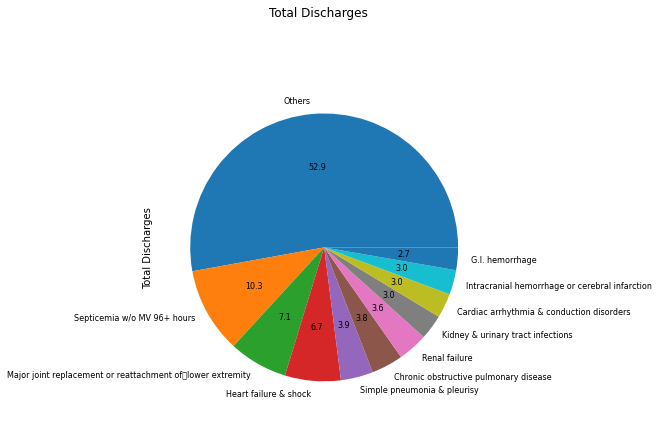

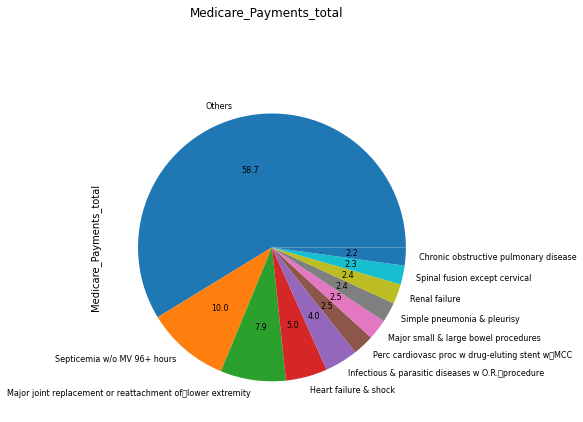

In [24]:
# Plotting & Analysing the Top 10 Health conditions contributing to most Medicare Payments

grp_plot('BASE_COND','pie',10,'Total Discharges','Medicare_Payments_total')

In [25]:
### FLAGGING OVERPAYMENTS at Provider Level (Payments Integrity)

# Establishing State level Baseline for Claims at each DRG Level

prov_avgs_st = prov.groupby(['Provider State','MS_DRG_CD'])['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'].sum()
prov_avgs_st = prov_avgs_st.assign(Mean_cov_Ch_st = prov_avgs_st.Covered_Charges_total/prov_avgs_st['Total Discharges'],
                            Mean_Pay_ttl_st = prov_avgs_st.Payments_total/prov_avgs_st['Total Discharges'],
                            Mean_MediPay_ttl_st = prov_avgs_st.Medicare_Payments_total/prov_avgs_st['Total Discharges'])
prov_avgs_st.drop(columns = ['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'],inplace=True)

# Establishing National level Baseline for Claims at each DRG Level

prov_avgs_ntl = prov.groupby(['MS_DRG_CD'])['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'].sum()
prov_avgs_ntl = prov_avgs_ntl.assign(Mean_cov_Ch_ntl = prov_avgs_ntl.Covered_Charges_total/prov_avgs_ntl['Total Discharges'],
                            Mean_Pay_ttl_ntl = prov_avgs_ntl.Payments_total/prov_avgs_ntl['Total Discharges'],
                            Mean_MediPay_ttl_ntl = prov_avgs_ntl.Medicare_Payments_total/prov_avgs_ntl['Total Discharges'])
prov_avgs_ntl.drop(columns = ['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'],inplace=True)

prov = prov.merge(prov_avgs_st, how='left',on=['Provider State','Provider City','MS_DRG_CD'])
prov = prov.merge(prov_avgs_ntl, how='left',on='MS_DRG_CD')

# Establish Payment Flags where Payment  at Provider level > State, National Levels, also establish multipliers
prov = prov.assign(st_flg_MediPay = prov['Average Medicare Payments'] > prov.Mean_MediPay_ttl_st,
                   ntl_flg_MediPay = prov['Average Medicare Payments'] > prov.Mean_MediPay_ttl_ntl,
                  st_mult_MediPay = prov['Average Medicare Payments']/prov.Mean_MediPay_ttl_st,
                  ntl_mult_MediPay = prov['Average Medicare Payments']/prov.Mean_MediPay_ttl_ntl)

# Print the multipliers for each provider           
prov.groupby(['Provider Id']).agg({'Total Discharges':'sum','st_mult_MediPay':'mean','ntl_mult_MediPay':'mean'}).sort_values(by='st_mult_MediPay',ascending=False)[:10]

# Flag Providers that are consistently overpaid, using multipliers after consultation with Business

Total Discharges  st_mult_MediPay  ntl_mult_MediPay
Provider Id                                                     
180153                     14              4.6               3.6
670111                     24              3.5               4.2
450865                     20              3.4               2.9
450289                   1976              3.0               3.1
190313                     59              2.7               3.4
50376                    1515              2.5               3.5
50373                    1866              2.3               3.6
450015                   7206              2.0               2.2
670116                     91              2.0               1.8
30022                     604              2.0               2.3

In [27]:
### FLAGGING OVERPAYMENTS at Provider Level (Payments Integrity) - Approach2 - ML Algorithm ( /.)

# LOF is a density-based outlier identification method. It flags outliers by analysing local spatial densities.

lof=LocalOutlierFactor()
yhat=lof.fit_predict(prov.set_index('Provider Id')[['Average Total Payments','Average Medicare Payments']])
prov['outlier'] = yhat

# Flag 'proportion' of outlier values among total values of Medicare Payments for each Provider

outl = 100*prov[prov.outlier==-1].groupby(['Provider Id'])['outlier'].count()/prov.groupby(['Provider Id'])['outlier'].count()
outl.dropna().sort_values(ascending=False).head(10)

Provider Id
330405   100.0
110209    55.6
50547     40.0
190313    20.0
340168    20.0
50541     10.5
390272    10.0
220062     9.1
210064     8.0
360365     7.7
Name: outlier, dtype: float64

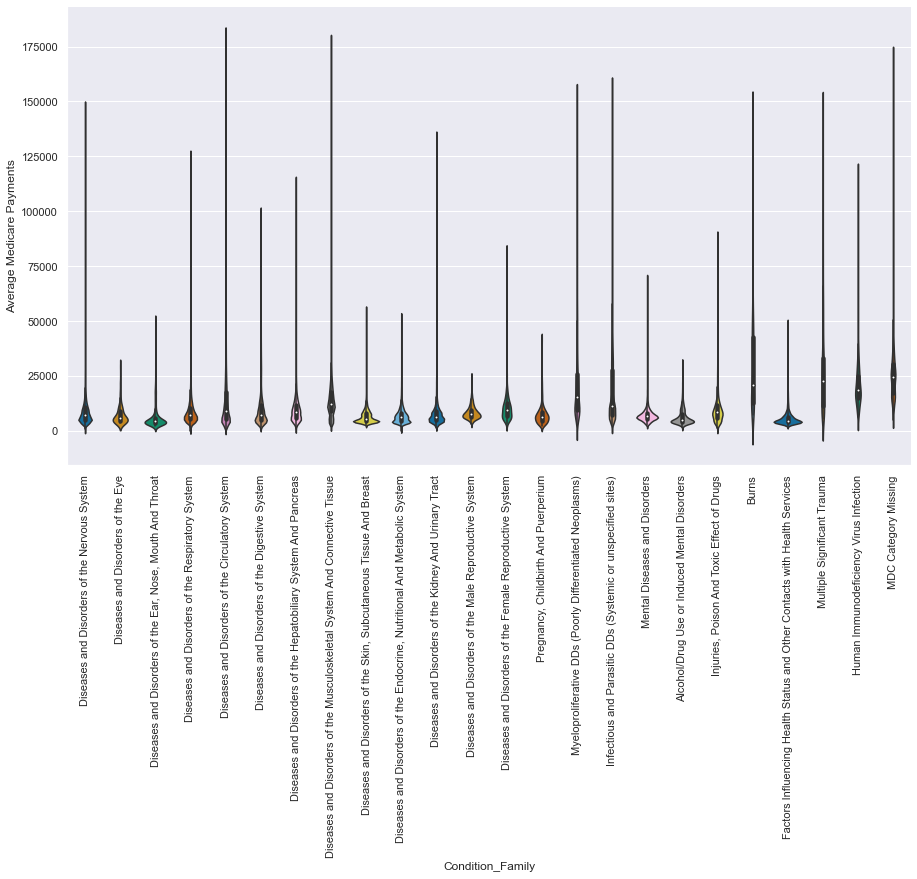

In [30]:
# Additional Plot 1 - Medicare Payments by Major Disease families

sns.set(style="darkgrid")
sns.catplot(data=prov[~prov.Condition_Family.isin(['Pre-MDC','Diseases and Disorders of the Blood and Blood Forming Organs and Immunological Disorders'])],x='Condition_Family',y='Average Medicare Payments',palette="colorblind",kind='violin',height = 7,aspect = 2,fontsize=8)
plt.xticks(rotation=90)
plt.show()

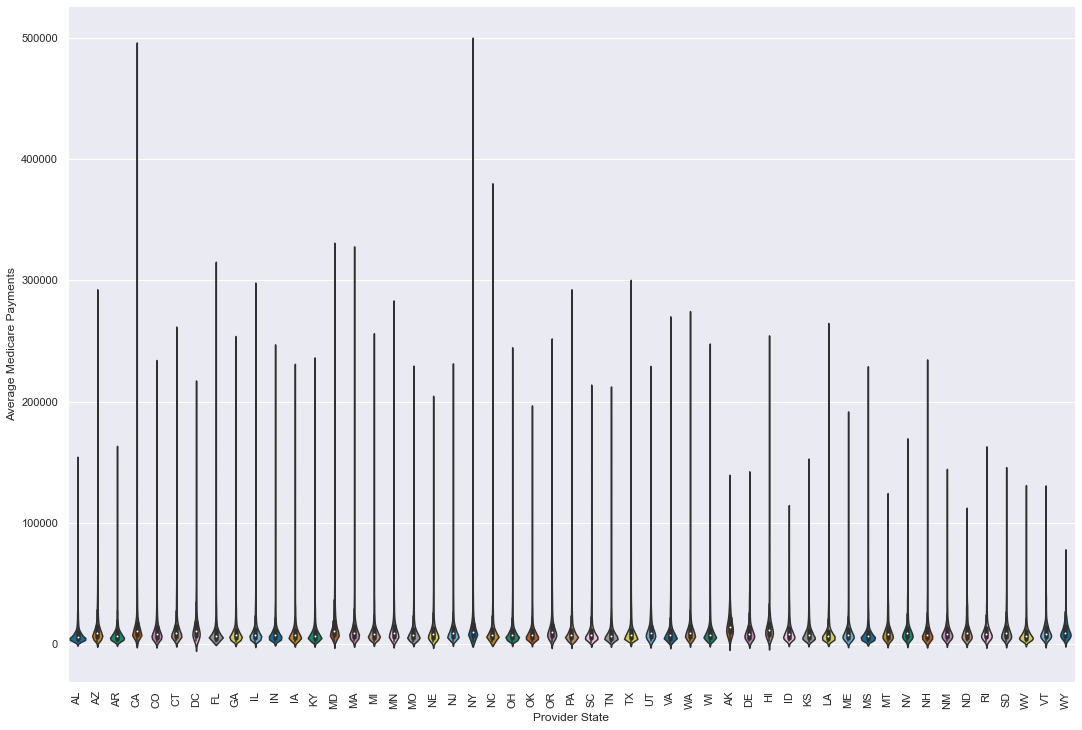

In [31]:
# Additional Plot 2 - Medicare Payments by States
sns.catplot(data=prov,x='Provider State',y='Average Medicare Payments',palette="colorblind",kind='violin',height = 10,aspect =1.5)
plt.xticks(rotation=90)
plt.show()

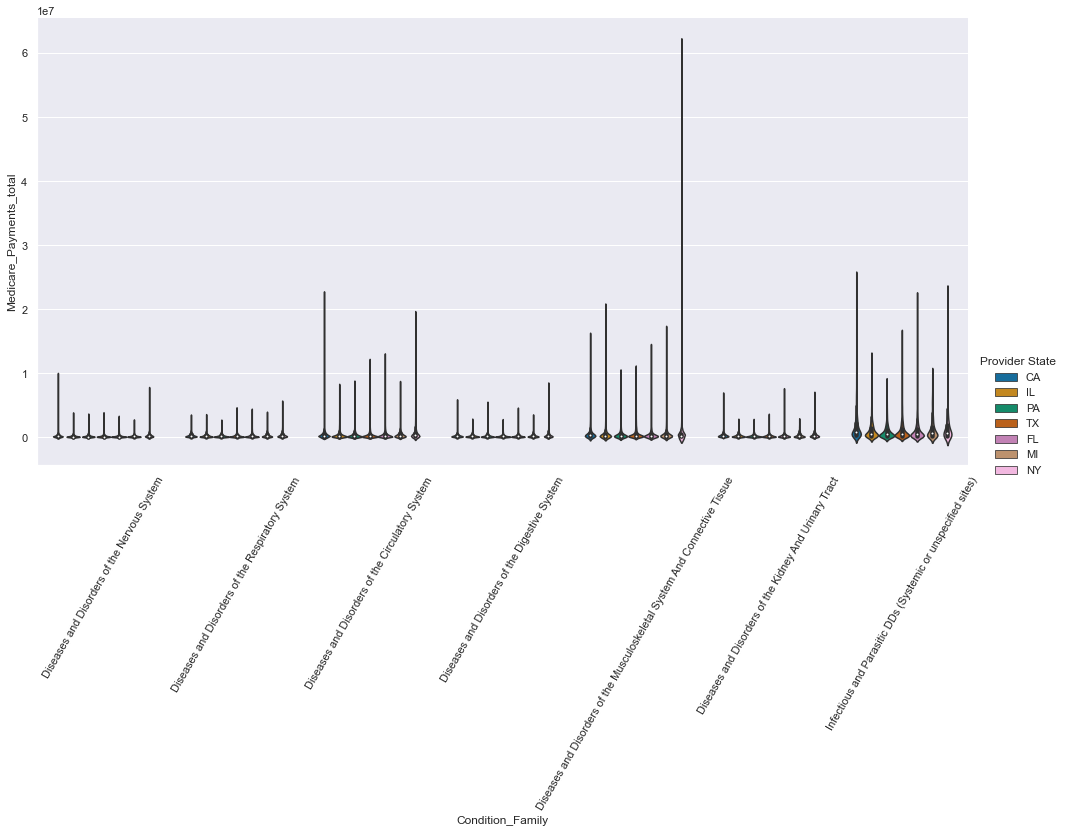

In [32]:
# Additional Plot 3 - Medicare Payments across Top 7 states for Top 7 Diseases

top7con = prov.groupby(['Condition_Family'])['Medicare_Payments_total'].sum().sort_values(ascending=False).reset_index().iloc[:7,0].tolist()
top7st = prov.groupby(['Provider State'])['Medicare_Payments_total'].sum().sort_values(ascending=False).reset_index().iloc[:7,0].tolist()

top7dfint = prov[prov.Condition_Family.isin(top7con)]
top7df = top7dfint[top7dfint['Provider State'].isin(top7st)]

sns.factorplot(x="Condition_Family", y="Medicare_Payments_total",data=top7df,palette="colorblind",kind='violin',size = 7,aspect = 2,hue='Provider State')
plt.xticks(rotation=60)
plt.show()

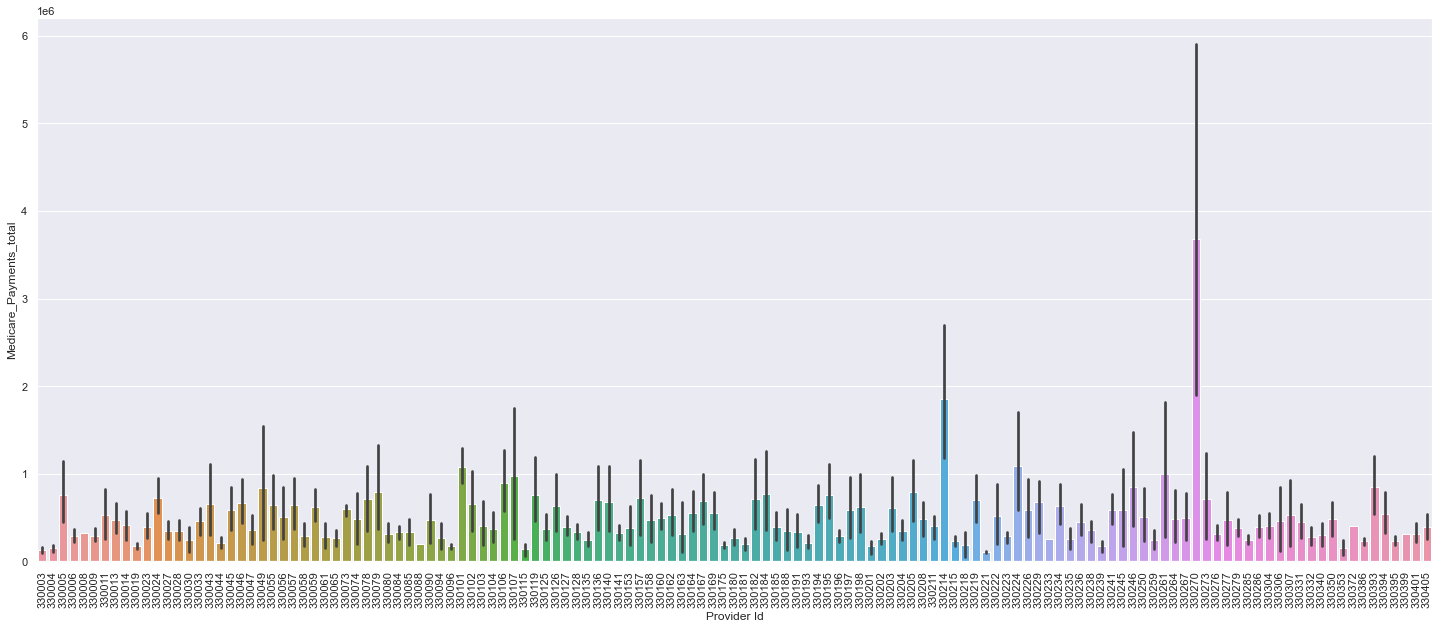

In [33]:
# Digging into skewed "NY - Disease & Disorders of Musculoskeletal System......." flagged in above plot

ny = top7df[(top7df['Provider State']=='NY') & (top7df.Condition_Family=='Diseases and Disorders of the Musculoskeletal System And Connective Tissue')]
plt.figure(figsize=(25,10))
sns.barplot(y=ny['Medicare_Payments_total'],x= ny['Provider Id'])
plt.xticks(rotation=90)
plt.show()

# Flagging outliers Providers in NY state derived from above aggregation

### Data Preparation & EDA - Inpatients Data

In [34]:
# Merge Additional info from CMS.gov & Wikipedia to Inpatients data

inpcl = inpcl.merge(table,how='left',on='IP_CLM_BASE_DRG_CD')
inpcl = pd.merge(inpcl,DRG_Class, how='left',on='MS_DRG_CD')

# Checking for Nan values
inpcl.isna().sum()

IP_CLM_ID                    0
BENE_SEX_IDENT_CD            0
BENE_AGE_CAT_CD              0
IP_CLM_BASE_DRG_CD           0
IP_CLM_ICD9_PRCDR_CD    633642
IP_CLM_DAYS_CD               0
IP_DRG_QUINT_PMT_AVG         0
IP_DRG_QUINT_PMT_CD          0
MS_DRG_CD                    0
BASE_COND                    0
MDC                       7783
Condition_Family             0
dtype: int64

In [14]:
inpcl.describe(include='all').fillna('-')

IP_CLM_ID BENE_SEX_IDENT_CD BENE_AGE_CAT_CD  \
count                588415         588,415.0       588,415.0   
unique               588415                 -               -   
top     IP-F072AF4816F655C9                 -               -   
freq                      1                 -               -   
mean                      -               1.6             3.6   
std                       -               0.5             1.8   
min                       -               1.0             1.0   
25%                       -               1.0             2.0   
50%                       -               2.0             4.0   
75%                       -               2.0             5.0   
max                       -               2.0             6.0   

       IP_CLM_BASE_DRG_CD IP_CLM_ICD9_PRCDR_CD IP_CLM_DAYS_CD  \
count           588,415.0            311,869.0      588,415.0   
unique                  -                    -              -   
top                     -                    -              -   
freq                    -                    -              -   
mean                140.2                 59.7            2.5   
std                  79.7                 29.2            1.0   
min                   1.0                  0.0            1.0   
25%                  82.0                 38.0            2.0   
50%                 123.0                 54.0            2.0   
75%                 200.0                 86.0            3.0   
max                 311.0                 99.0            4.0   

       IP_DRG_QUINT_PMT_AVG IP_DRG_QUINT_PMT_CD  
count             588,415.0           588,415.0  
unique                    -                   -  
top                       -                   -  
freq                      -                   -  
mean                9,312.6                 3.0  
std                10,482.7                 1.4  
min                     0.0                 1.0  
25%                 4,008.0                 2.0  
50%                 6,352.0                 3.0  
75%                10,760.0                 4.0  
max               329,467.0                 5.0

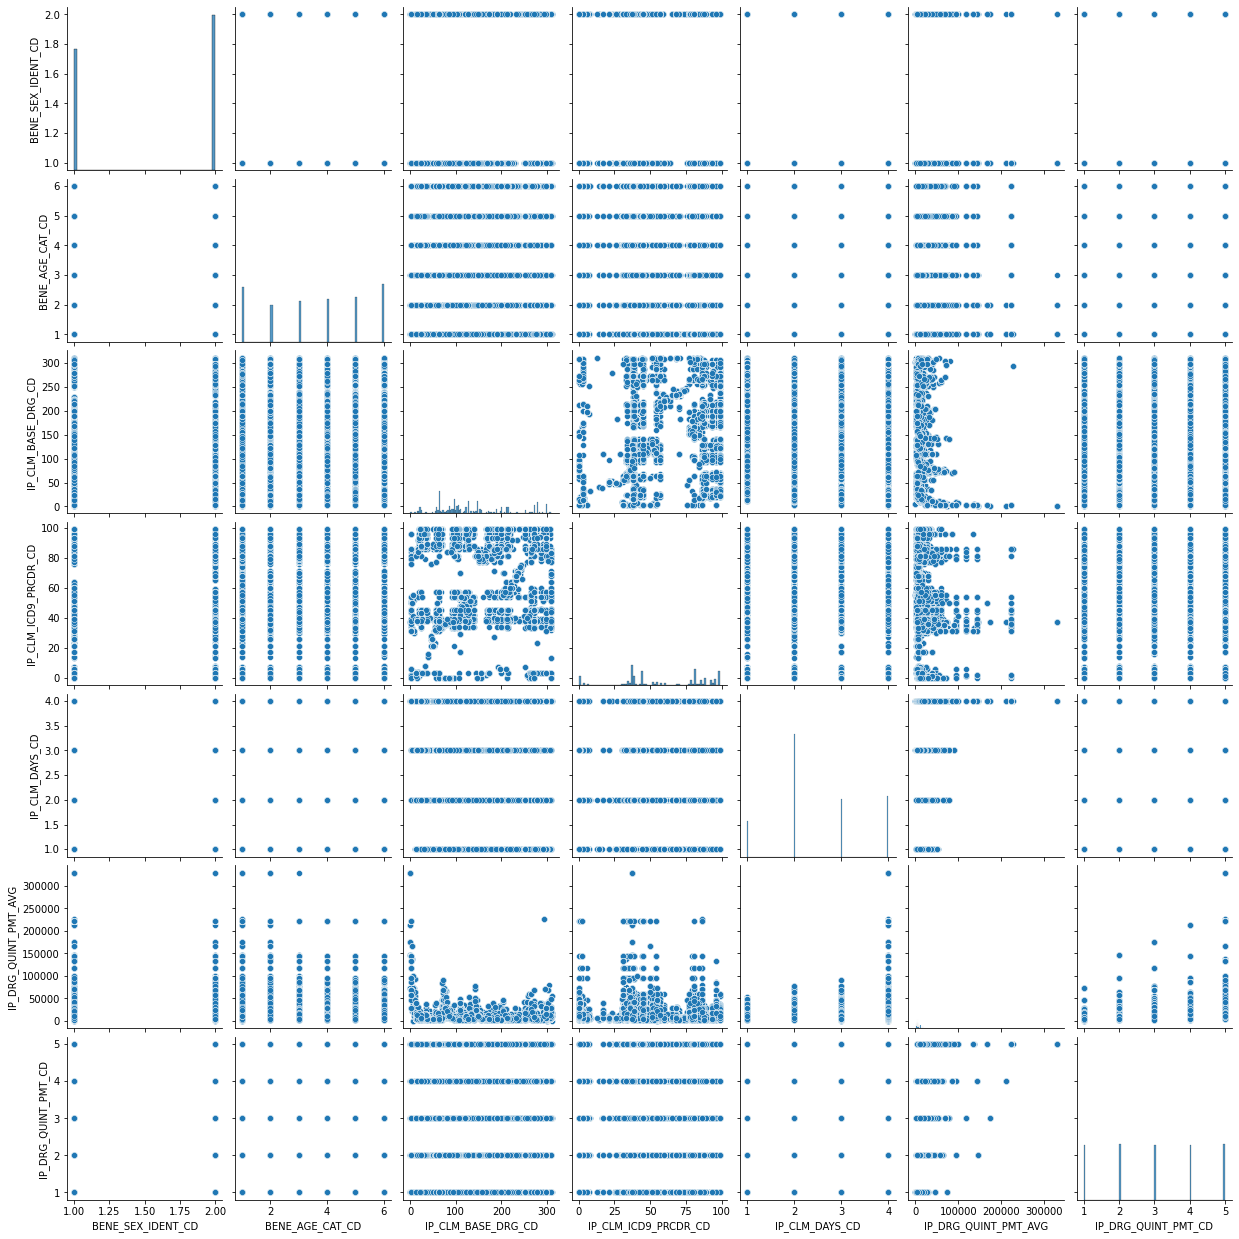

In [292]:
sns.pairplot(inpcl)
plt.show()

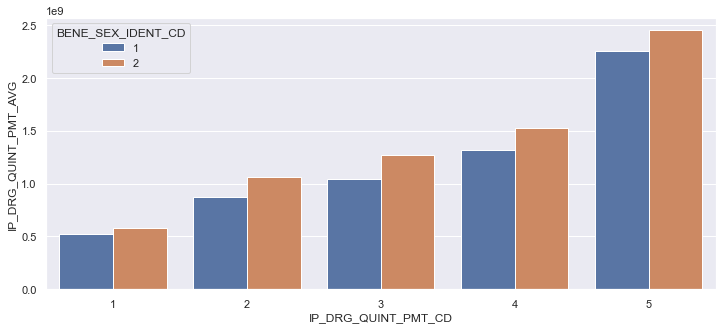

In [36]:
# Plotting Genderwise differences across the 5 quintiles of Payments basis 'IP_DRG_QUINT_PMT_CD' field
fig = plt.gcf()
fig.set_size_inches(12,5)
sns.barplot(data=inpcl.groupby(['IP_DRG_QUINT_PMT_CD','BENE_SEX_IDENT_CD'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index(), x= 'IP_DRG_QUINT_PMT_CD',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_SEX_IDENT_CD')
plt.show()

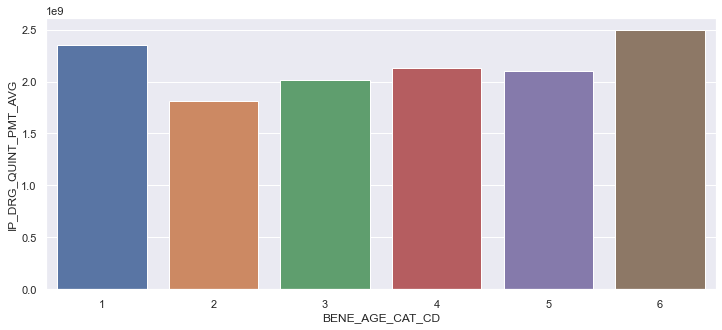

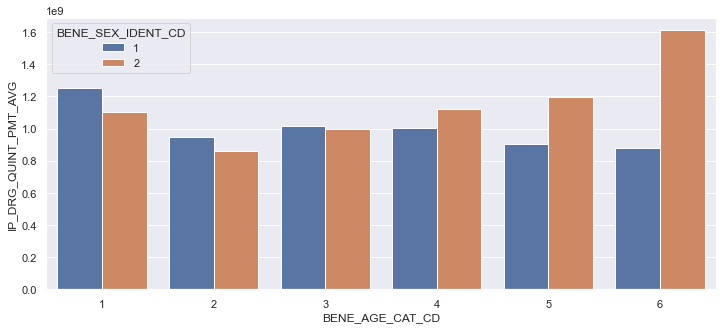

In [37]:
# Plotting Genderwise Avg Claim differences across Quintiles basis 'IP_DRG_QUINT_PMT_CD' field  

fig = plt.gcf()
fig.set_size_inches(12,5)
sns.barplot(data=inpcl.groupby(['BENE_AGE_CAT_CD'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index(), x= 'BENE_AGE_CAT_CD',y='IP_DRG_QUINT_PMT_AVG')
plt.show()

# Plotting Avg Claim differences across the 5 age categories, subdivided by gender

fig = plt.gcf()
fig.set_size_inches(12,5)
sns.barplot(data=inpcl.groupby(['BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index(), x= 'BENE_AGE_CAT_CD',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_SEX_IDENT_CD')
plt.show()

# Avg Claim amounts for Females > Males for younger-age categories whereas Avg Claims for males > females for older age categories 


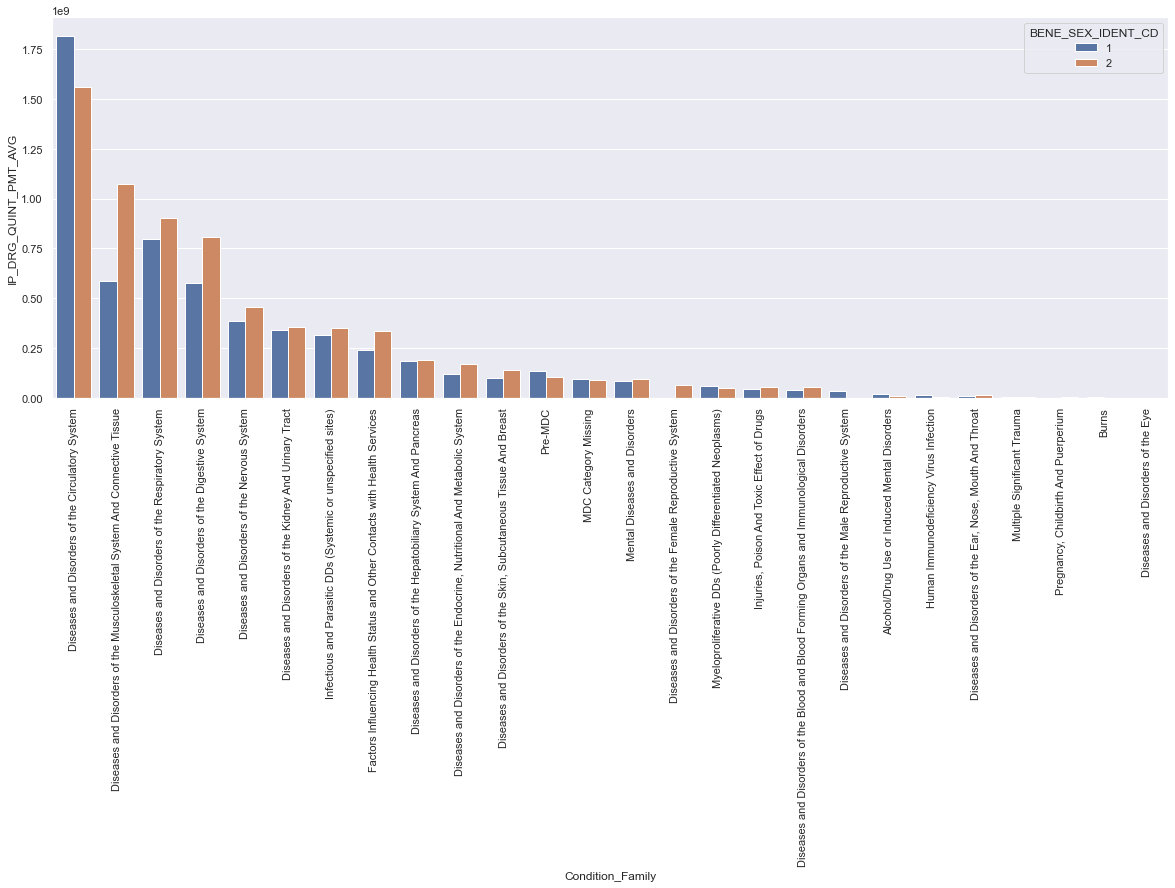

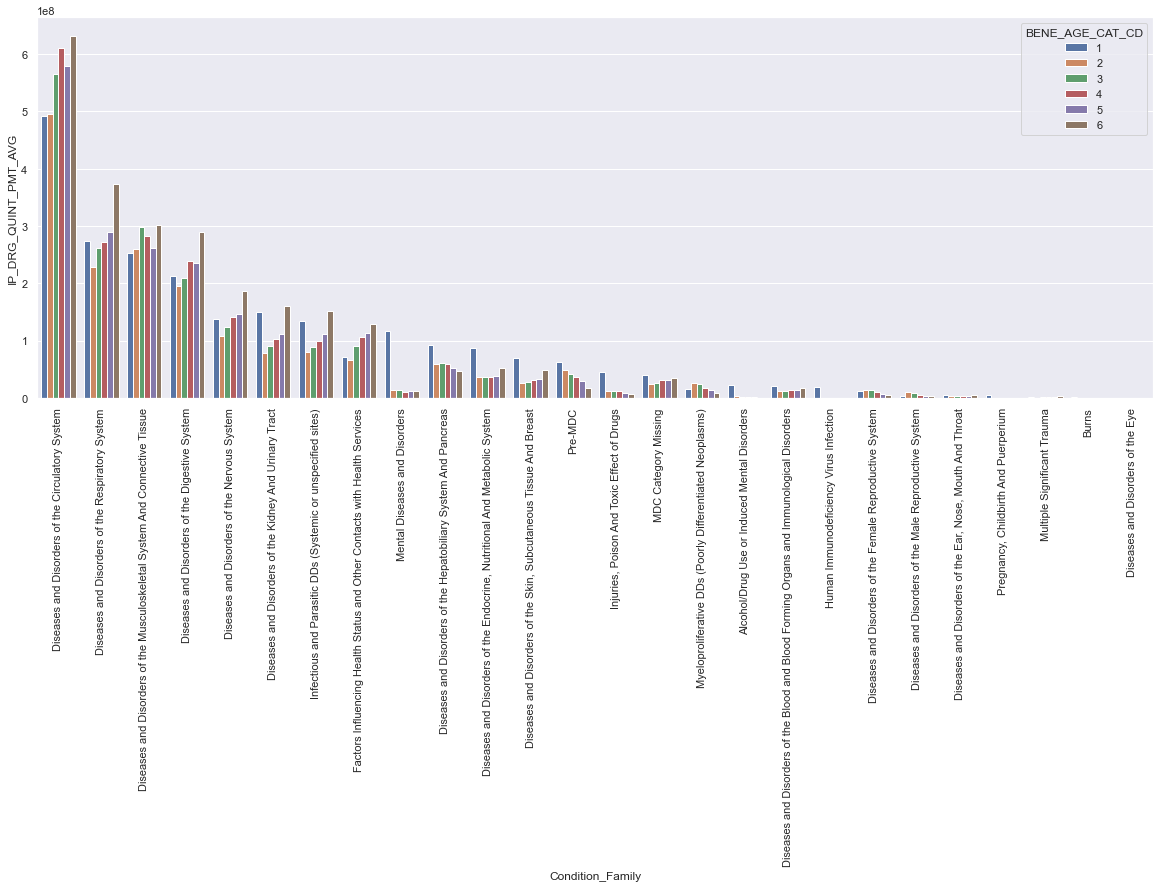

In [38]:
# Plotting Claim Amount differences across Major disease, subdivided by Gender

fig = plt.gcf()
fig.set_size_inches(20,7)
sns.barplot(data=inpcl.groupby(['BENE_SEX_IDENT_CD','Condition_Family'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index().sort_values(by='IP_DRG_QUINT_PMT_AVG',ascending=False), x= 'Condition_Family',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_SEX_IDENT_CD')
plt.xticks(rotation=90)
plt.show()

# Plotting Claim Amount differences across Major disease, subdivided by Age Categories

fig = plt.gcf()
fig.set_size_inches(20,7)
sns.barplot(data=inpcl.groupby(['BENE_AGE_CAT_CD','Condition_Family'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index().sort_values(by='IP_DRG_QUINT_PMT_AVG',ascending=False), x= 'Condition_Family',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_AGE_CAT_CD')
plt.xticks(rotation=90)
plt.show()

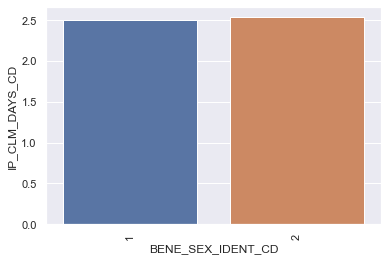

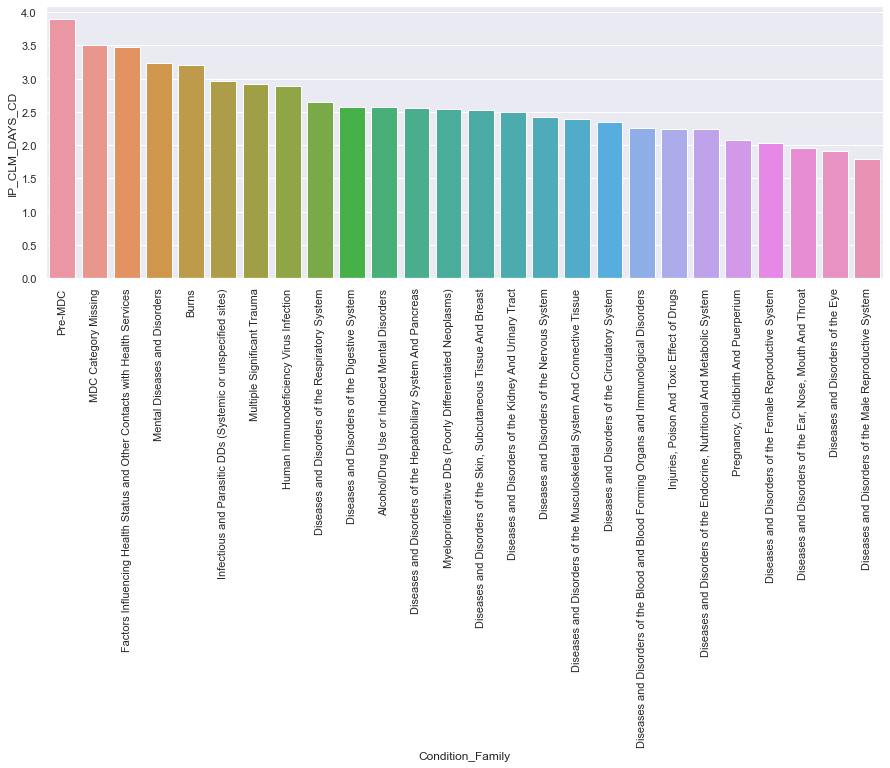

In [39]:
#Average hospital stay across Genders

sns.barplot(data=inpcl.groupby(['BENE_SEX_IDENT_CD'])['IP_CLM_DAYS_CD'].mean().reset_index().sort_values(by='IP_CLM_DAYS_CD',ascending=False), x= 'BENE_SEX_IDENT_CD',y='IP_CLM_DAYS_CD')
plt.xticks(rotation=90)
plt.show()

#Average hospital stay across different Age Categories

fig = plt.gcf()
fig.set_size_inches(15,5)
sns.barplot(data=inpcl.groupby(['Condition_Family'])['IP_CLM_DAYS_CD'].mean().reset_index().sort_values(by='IP_CLM_DAYS_CD',ascending=False), x= 'Condition_Family',y='IP_CLM_DAYS_CD')
plt.xticks(rotation=90)
plt.show()

In [42]:
### FLAGGING OUTLIER CLAIMS - Approach 1 - using Category Averages

test = inpcl[['IP_CLM_ID','BASE_COND','BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG']]

# Flagging Top 0.1% & Bottom 0.1% Claims across each 'Gender-Age-DRG' Combination as Outliers

outliers = pd.DataFrame()
for cond in test[['IP_CLM_ID','BASE_COND','BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG']].BASE_COND.unique():
    df = test[test.BASE_COND==cond]
    df = df[['IP_CLM_ID','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG']].set_index('IP_CLM_ID')
    for cat in df.BENE_AGE_CAT_CD:
        dff = df[df.BENE_AGE_CAT_CD==cat]
        df_low = dff['IP_DRG_QUINT_PMT_AVG'].quantile(0.001)
        df_hi  = dff['IP_DRG_QUINT_PMT_AVG'].quantile(0.999)
    
        outliers = outliers.append(df[(df['IP_DRG_QUINT_PMT_AVG'] > df_hi)])
        outliers.append(df[(df["Medicare_Payments_total"] < df_low)])
    
outliers.head(10)

BENE_AGE_CAT_CD  IP_DRG_QUINT_PMT_AVG
IP_CLM_ID                                                 
IP-000D31A70A92CF79                6                 10001
IP-000D31A70A92CF79                6                 10001
IP-000D31A70A92CF79                6                 10001
IP-0014AE4C533BFF8F                6                  5497
IP-0014AE4C533BFF8F                6                  5497
IP-0014AE4C533BFF8F                6                  5497
IP-0019A36D0FD66E37                1                  5497
IP-0019A36D0FD66E37                1                  5497
IP-0019A36D0FD66E37                1                  5497
IP-002FC7307D45E377                6                  5497

In [41]:
### Flagging Outlier claims - Machine Learning Approach (Local Outlier Factor Algorithm)

# LOF is a density-based outlier identification method. It flags outliers by analysing local spatial densities.

lof=LocalOutlierFactor()
yhat=lof.fit_predict(inpcl.set_index('IP_CLM_ID')[['BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG','IP_CLM_DAYS_CD']])
inpcl['outlier'] = yhat
inpcl.loc[inpcl.outlier==-1].sort_values(by='IP_DRG_QUINT_PMT_AVG',ascending=False)[:10]

IP_CLM_ID  BENE_SEX_IDENT_CD  BENE_AGE_CAT_CD  \
1202041  IP-DB9DBD5D3347CB7C                  1                1   
962950   IP-B0196C9760EE4171                  1                1   
1114816  IP-CBC958F3249DE04B                  1                2   
306522   IP-383476FDDCD89CAE                  2                1   
260246   IP-2FB50776371E910D                  2                1   
411687   IP-4B3872DD43E8FD01                  2                1   
1110430  IP-CAFB188CDA4D38E9                  1                2   
1254532  IP-E5459100C94C9EA8                  1                2   
1112206  IP-CB4D6C19FBC715D7                  1                2   
1336284  IP-F43225B091E405DE                  1                2   

         IP_CLM_BASE_DRG_CD  IP_CLM_ICD9_PRCDR_CD  IP_CLM_DAYS_CD  \
1202041                 294                  86.0               4   
962950                  294                  86.0               4   
1114816                   2                  45.0               4   
306522                    2                  86.0               4   
260246                    2                  39.0               4   
411687                    2                  50.0               4   
1110430                   2                  81.0               4   
1254532                   2                  34.0               4   
1112206                   2                  36.0               4   
1336284                   2                  31.0               4   

         IP_DRG_QUINT_PMT_AVG  IP_DRG_QUINT_PMT_CD  MS_DRG_CD  \
1202041                226550                    5        927   
962950                 226550                    5        927   
1114816                222276                    5          3   
306522                 222276                    5          3   
260246                 222276                    5          3   
411687                 222276                    5          3   
1110430                222276                    5          3   
1254532                222276                    5          3   
1112206                222276                    5          3   
1336284                222276                    5          3   

                                                                   BASE_COND  \
1202041   Extensive burns or full thickness burns w MV\r96+ hrs w skin graft   
962950    Extensive burns or full thickness burns w MV\r96+ hrs w skin graft   
1114816  ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
306522   ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
260246   ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
411687   ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
1110430  ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
1254532  ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
1112206  ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   
1336284  ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.   

         MDC Condition_Family  outlier  
1202041 22.0            Burns       -1  
962950  22.0            Burns       -1  
1114816  0.0          Pre-MDC       -1  
306522   0.0          Pre-MDC       -1  
260246   0.0          Pre-MDC       -1  
411687   0.0          Pre-MDC       -1  
1110430  0.0          Pre-MDC       -1  
1254532  0.0          Pre-MDC       -1  
1112206  0.0          Pre-MDC       -1  
1336284  0.0          Pre-MDC       -1